In [77]:
from pathlib import Path

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sn

import importlib
import plotting
import model_utils
import models
import utils
import scipy

print(scipy.__version__)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sn.set_theme(style="ticks", rc=custom_params)

rng = np.random.default_rng()

from scipy.special import expit as logistic

1.11.1


In [78]:
importlib.reload(utils)
importlib.reload(model_utils)
importlib.reload(models)
importlib.reload(plotting);

# Comparison different filtering techniques

In [57]:
from typing import Dict
from matplotlib.gridspec import GridSpec

def _load_traces_to_dict(path: Path) -> Dict[str, az.InferenceData]:
    res = {}
    for p in path.glob("*.nc"):
        trace = az.from_netcdf(p)
        if "y_real" in trace.log_likelihood.data_vars:
            trace.log_likelihood["y"] = trace.log_likelihood["y_real"] + trace.log_likelihood["y_fake"]
        p_str = str(p)
        name = p_str[p_str.rfind("/") + 1:].replace(".nc", "")

        res[name] = trace

    return res

def compare_techniques(category: str, media: str):
    median_traces = _load_traces_to_dict(Path(f"traces/{category}/half-median/demographics/{media}"))
    interval_traces = _load_traces_to_dict(Path(f"traces/{category}/interval/demographics/{media}"))

    median_compare = az.compare(median_traces, var_name="y")
    interval_compare = az.compare(interval_traces, var_name="y")
    fig = plt.figure(figsize=(12, len(median_compare)), facecolor="white")
    gs = GridSpec(1, 2, figure=fig)

    ax = fig.add_subplot(gs[0, 0])
    az.plot_compare(median_compare, ax=ax)
    ax.set_title("Median Filtering")

    ax = fig.add_subplot(gs[0, 1])
    az.plot_compare(interval_compare, ax=ax)
    ax.set_title("Interval Filtering")

    fig.suptitle(f"{category.title()} ({media.title()})")

compare_techniques("accuracy", "audio")
compare_techniques("accuracy", "image")
compare_techniques("accuracy", "text")

compare_techniques("real_fake", "audio")
compare_techniques("real_fake", "image")
compare_techniques("real_fake", "text")

KeyError: 'elpd_loo'

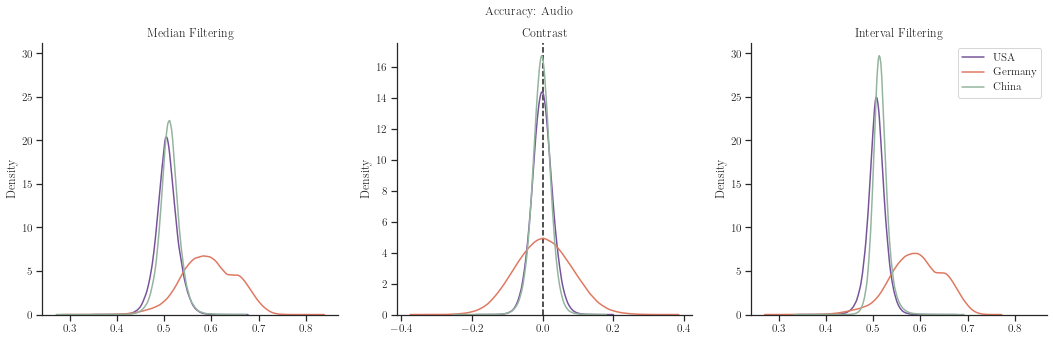

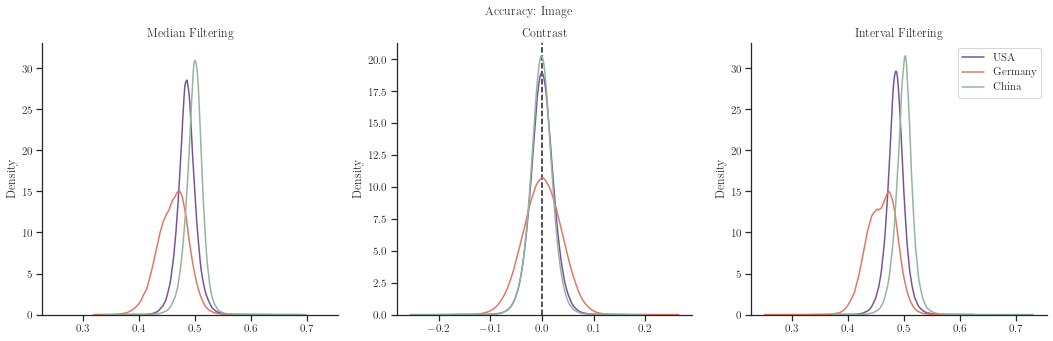

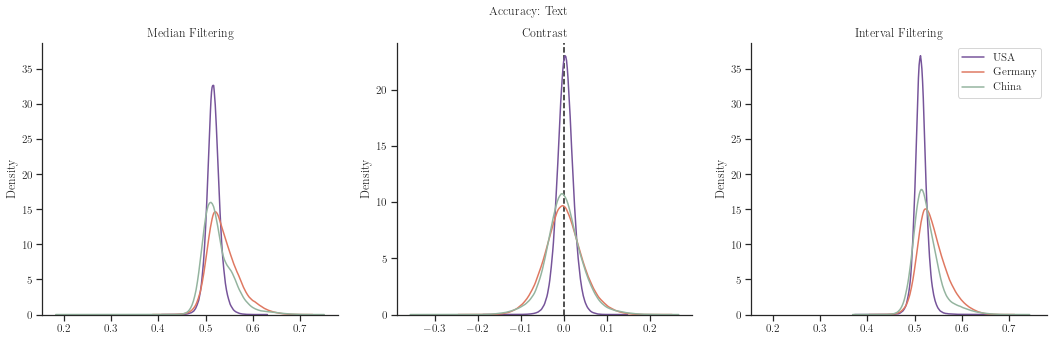

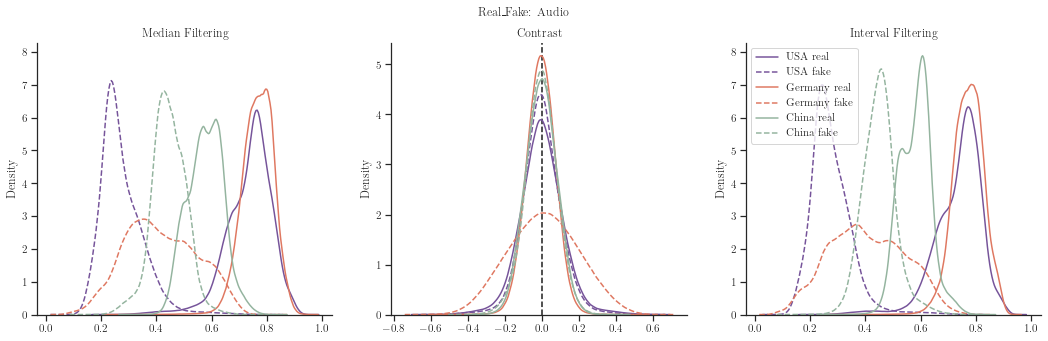

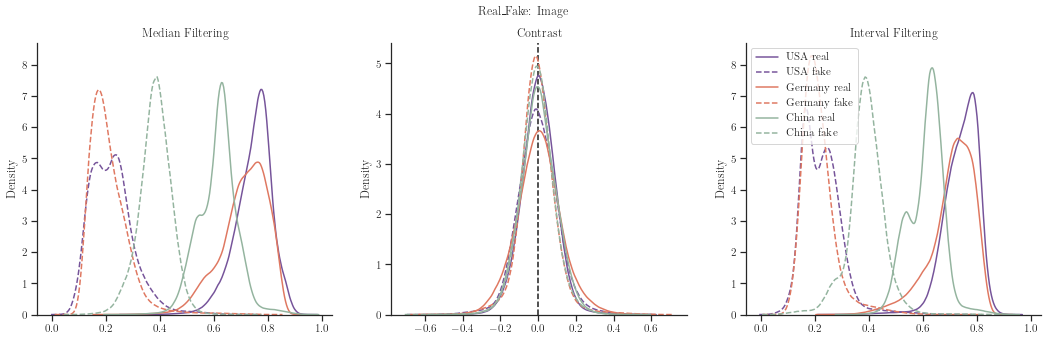

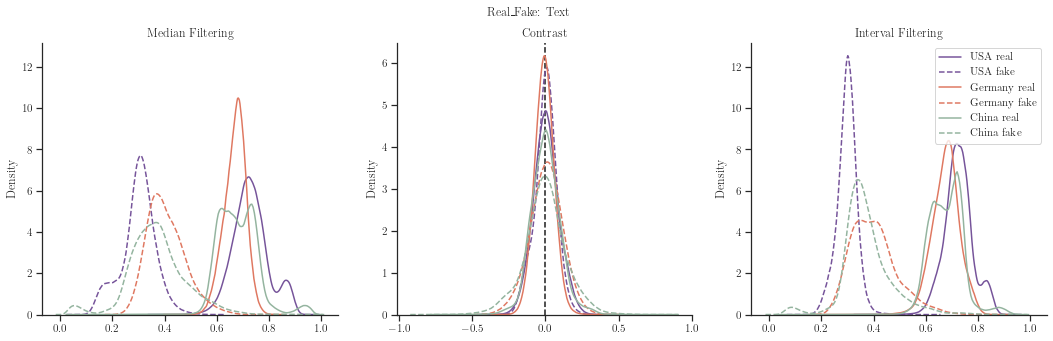

In [5]:
from utils import COUNTRIES
from plotting import COLORS

def plot_accuracy(median_trace: az.InferenceData, interval_trace: az.InferenceData, title: str, category: str = "accuracy"):
    fig = plt.figure(figsize=(18, 5), facecolor="white")
    gs = GridSpec(1, 3, figure=fig)
    colors = COLORS[-1]

    median_ax = fig.add_subplot(gs[0, 0])
    median_ax.set_title("Median Filtering")

    contrast_ax = fig.add_subplot(gs[0, 1])
    contrast_ax.set_title("Contrast")
    contrast_ax.axvline(0, color="k", linestyle="--")

    interval_ax = fig.add_subplot(gs[0, 2], sharex=median_ax, sharey=median_ax)
    interval_ax.set_title("Interval Filtering")

    for i, country in enumerate(COUNTRIES):
        median_idx = median_trace.constant_data.country_idx.values == i
        interval_idx = interval_trace.constant_data.country_idx.values == i

        if category == "accuracy":
            median_data = median_trace.posterior.pi[:,:, median_idx].values.flatten()
            interval_data = interval_trace.posterior.pi[:,:, interval_idx].values.flatten()
            sn.kdeplot(median_data, color=colors[i], ax=median_ax)
            sn.kdeplot(interval_data, color=colors[i], label=country, ax=interval_ax)

            n = min(len(median_data), len(interval_data))
            contrast = median_data[:n] - interval_data[:n]
            sn.kdeplot(contrast, color=colors[i], ax=contrast_ax)
        else:
            median_data_real = median_trace.posterior.pi_real[:,:, median_idx].values.flatten()
            median_data_fake = median_trace.posterior.pi_fake[:,:, median_idx].values.flatten()
            sn.kdeplot(median_data_real, color=colors[i], ax=median_ax)
            sn.kdeplot(median_data_fake, color=colors[i], linestyle="--", ax=median_ax)

            interval_data_real = interval_trace.posterior.pi_real[:,:, interval_idx].values.flatten()
            interval_data_fake = interval_trace.posterior.pi_fake[:,:, interval_idx].values.flatten()
            sn.kdeplot(interval_data_real, color=colors[i], label=f"{country} real", ax=interval_ax)
            sn.kdeplot(interval_data_fake, color=colors[i], linestyle="--", label=f"{country} fake", ax=interval_ax)

            n_real = min(len(median_data_real), len(interval_data_real))
            contrast_real = median_data_real[:n_real] - interval_data_real[:n_real]

            n_fake = min(len(median_data_fake), len(interval_data_fake))
            contrast_fake = median_data_fake[:n_fake] - interval_data_fake[:n_fake]
            sn.kdeplot(contrast_real, color=colors[i], ax=contrast_ax)
            sn.kdeplot(contrast_fake, color=colors[i], linestyle="--", ax=contrast_ax)

    interval_ax.legend()
    fig.suptitle(f"{category.title()}: {title}")

median_trace = az.from_netcdf("traces/accuracy/half-median/demographics/audio/age_edu.nc")
interval_trace = az.from_netcdf("traces/accuracy/interval/demographics/audio/age_edu.nc")
plot_accuracy(median_trace, interval_trace, "Audio")

median_trace = az.from_netcdf("traces/accuracy/half-median/demographics/image/age_edu.nc")
interval_trace = az.from_netcdf("traces/accuracy/interval/demographics/image/age_edu.nc")
plot_accuracy(median_trace, interval_trace, "Image")

median_trace = az.from_netcdf("traces/accuracy/half-median/demographics/text/age.nc")
interval_trace = az.from_netcdf("traces/accuracy/interval/demographics/text/age.nc")
plot_accuracy(median_trace, interval_trace, "Text")


median_trace = az.from_netcdf("traces/real_fake/half-median/demographics/audio/age_edu.nc")
interval_trace = az.from_netcdf("traces/real_fake/interval/demographics/audio/age_edu.nc")
plot_accuracy(median_trace, interval_trace, "Audio", "real_fake")

median_trace = az.from_netcdf("traces/real_fake/half-median/demographics/image/age_edu.nc")
interval_trace = az.from_netcdf("traces/real_fake/interval/demographics/image/age_edu.nc")
plot_accuracy(median_trace, interval_trace, "Image", "real_fake")

median_trace = az.from_netcdf("traces/real_fake/half-median/demographics/text/age.nc")
interval_trace = az.from_netcdf("traces/real_fake/interval/demographics/text/age.nc")
plot_accuracy(median_trace, interval_trace, "Text", "real_fake")

# Contrast between Fake and Real Accuracy

In [5]:
audio_real_fake, image_real_fake, text_real_fake = model_utils.load_acc_data(real_fake=True, filter_type="interval")

merged = pd.concat((audio_real_fake, image_real_fake, text_real_fake))

users_per_country = merged.groupby(["country"])["id"].nunique()
users_per_country, users_per_country.sum()

Filtering: 152 user using the 95% interval!
Filtered another 73 users!
Filtered another 126 users!
Filtered another 38 users!


(country
 China      909
 Germany    868
 USA        816
 Name: id, dtype: int64,
 2593)

In [6]:
base_audio_trace = az.from_netcdf("traces/real_fake/interval/demographics/audio/base.nc").load()
time_audio_trace = az.from_netcdf("traces/real_fake/interval/demographics/audio/time.nc").load()
time_edu_audio_trace = az.from_netcdf("traces/real_fake/interval/demographics/audio/time_edu.nc").load()
time_age_audio_trace = az.from_netcdf("traces/real_fake/interval/demographics/audio/time_age.nc").load()
time_age_edu_audio_trace = az.from_netcdf("traces/real_fake/interval/demographics/audio/time_age_edu.nc").load()
edu_audio_trace = az.from_netcdf("traces/real_fake/interval/demographics/audio/edu.nc").load()
age_audio_trace = az.from_netcdf("traces/real_fake/interval/demographics/audio/age.nc").load()
age_edu_audio_trace = az.from_netcdf("traces/real_fake/interval/demographics/audio/age_edu.nc").load()

base_image_trace = az.from_netcdf("traces/real_fake/interval/demographics/image/base.nc").load()
time_image_trace = az.from_netcdf("traces/real_fake/interval/demographics/image/time.nc").load()
time_edu_image_trace = az.from_netcdf("traces/real_fake/interval/demographics/image/time_edu.nc").load()
time_age_image_trace = az.from_netcdf("traces/real_fake/interval/demographics/image/time_age.nc").load()
time_age_edu_image_trace = az.from_netcdf("traces/real_fake/interval/demographics/image/time_age_edu.nc").load()
edu_image_trace = az.from_netcdf("traces/real_fake/interval/demographics/image/edu.nc").load()
age_image_trace = az.from_netcdf("traces/real_fake/interval/demographics/image/age.nc").load()
age_edu_image_trace = az.from_netcdf("traces/real_fake/interval/demographics/image/age_edu.nc").load()

base_text_trace = az.from_netcdf("traces/real_fake/interval/demographics/text/base.nc").load()
time_text_trace = az.from_netcdf("traces/real_fake/interval/demographics/text/time.nc").load()
time_edu_text_trace = az.from_netcdf("traces/real_fake/interval/demographics/text/time_edu.nc").load()
time_age_text_trace = az.from_netcdf("traces/real_fake/interval/demographics/text/time_age.nc").load()
time_age_edu_text_trace = az.from_netcdf("traces/real_fake/interval/demographics/text/time_age_edu.nc").load()
edu_text_trace = az.from_netcdf("traces/real_fake/interval/demographics/text/edu.nc").load()
age_text_trace = az.from_netcdf("traces/real_fake/interval/demographics/text/age.nc").load()
age_edu_text_trace = az.from_netcdf("traces/real_fake/interval/demographics/text/age_edu.nc").load()

demographic_traces = [
    base_audio_trace, time_audio_trace, edu_audio_trace, age_audio_trace, age_edu_audio_trace, time_edu_audio_trace, time_age_audio_trace, time_age_edu_audio_trace,
    base_image_trace, time_image_trace, edu_image_trace, age_image_trace, age_edu_image_trace, time_edu_image_trace, time_age_image_trace, time_age_edu_image_trace,
    base_text_trace, time_text_trace, edu_text_trace, age_text_trace, age_edu_text_trace, time_edu_text_trace, time_age_text_trace, time_age_edu_text_trace,
]

for trace in demographic_traces:
    trace.log_likelihood["y"] = trace.log_likelihood["y_real"] + trace.log_likelihood["y_fake"]

/Users/joelfrank/.pyenv/versions/3.10.7/envs/datascience/lib/python3.10/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/joelfrank/.pyenv/versions/3.10.7/envs/datascience/lib/python3.10/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.wa

Text(0.5, 1.0, 'Audio')

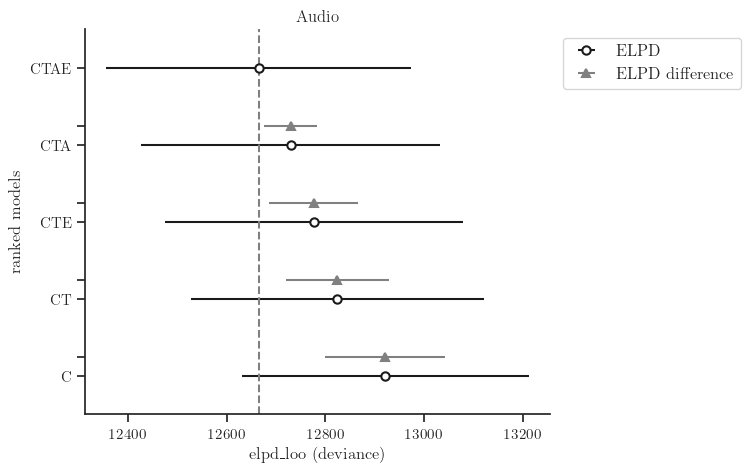

In [7]:
audio_compare = az.compare({
    "C": base_audio_trace,
    # "edu": edu_audio_trace,
    # "age": age_audio_trace,
    # "age edu": age_edu_audio_trace,
    "CT": time_audio_trace,
    "CTE": time_edu_audio_trace,
    "CTA": time_age_audio_trace,
    "CTAE": time_age_edu_audio_trace,
}, var_name="y", scale="deviance").round(2)
az.plot_compare(audio_compare)
plt.title("Audio")

In [8]:
audio_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
CTAE,0,12664.84,360.94,0.00,0.40,309.09,0.00,True,deviance
CTA,1,12729.31,324.10,64.47,0.17,303.81,53.16,True,deviance
CTE,2,12776.17,93.19,111.32,0.17,302.54,89.87,False,deviance
CT,3,12823.93,52.48,159.08,0.00,297.49,103.97,False,deviance
C,4,12921.61,28.91,256.76,0.26,291.69,121.53,False,deviance


/Users/joelfrank/.pyenv/versions/3.10.7/envs/datascience/lib/python3.10/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/joelfrank/.pyenv/versions/3.10.7/envs/datascience/lib/python3.10/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.wa

Text(0.5, 1.0, 'Image')

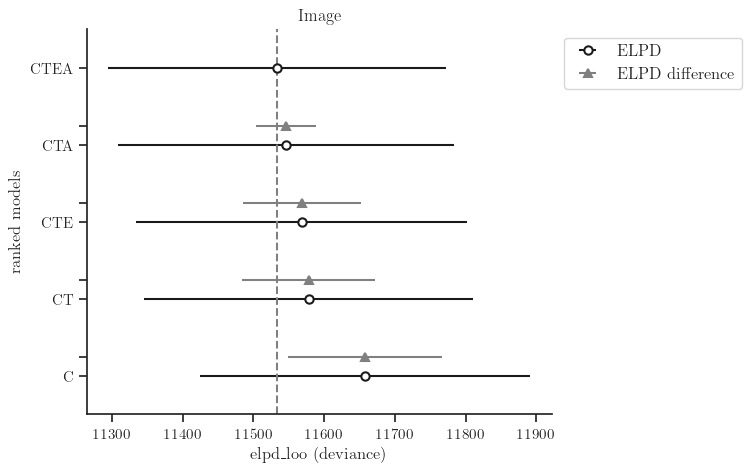

In [9]:
image_compare = az.compare({
    "C": base_image_trace,
    # "edu": edu_image_trace,
    # "age": age_image_trace,
    # "age edu": age_edu_image_trace,
    "CT": time_image_trace,
    "CTE": time_edu_image_trace,
    "CTA": time_age_image_trace,
    "CTEA": time_age_edu_image_trace,
}, var_name="y", scale="deviance").round(2)
az.plot_compare(image_compare, insample_dev=False)
plt.title("Image")

In [10]:
image_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
CTEA,0,11532.82,373.95,0.00,0.39,238.92,0.00,True,deviance
CTA,1,11546.41,321.90,13.59,0.14,237.98,42.60,True,deviance
CTE,2,11568.45,103.38,35.63,0.14,234.33,83.13,False,deviance
CT,3,11577.99,52.05,45.17,0.05,233.03,93.75,True,deviance
C,4,11657.92,27.12,125.11,0.27,233.89,109.01,False,deviance


/Users/joelfrank/.pyenv/versions/3.10.7/envs/datascience/lib/python3.10/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/joelfrank/.pyenv/versions/3.10.7/envs/datascience/lib/python3.10/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.wa

Text(0.5, 1.0, 'Text')

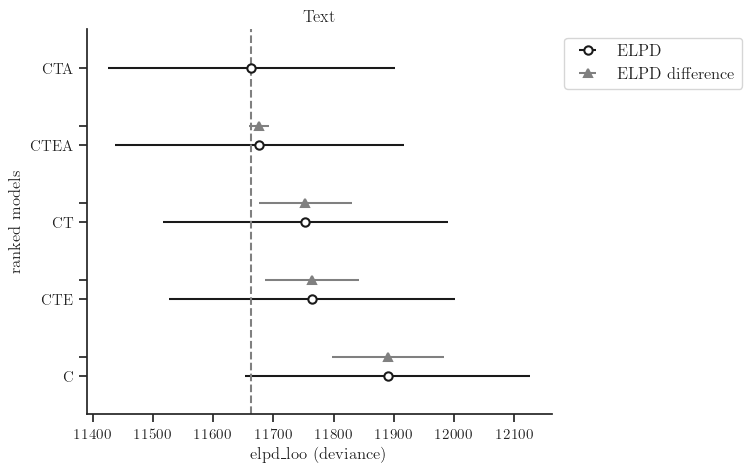

In [11]:
text_compare = az.compare({
    "C": base_text_trace,
    # "edu": edu_text_trace,
    # "age": age_text_trace,
    # "age edu": age_edu_text_trace,
    "CT": time_text_trace,
    "CTE": time_edu_text_trace,
    "CTA": time_age_text_trace,
    "CTEA": time_age_edu_text_trace,
}, var_name="y", scale="deviance").round(2)
az.plot_compare(text_compare, insample_dev=False)
plt.title("Text")

In [12]:
text_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
CTA,0,11663.29,244.53,0.00,0.32,238.15,0.00,True,deviance
CTEA,1,11676.71,271.96,13.42,0.20,239.45,16.79,True,deviance
CT,2,11752.84,38.04,89.55,0.03,236.32,77.29,False,deviance
CTE,3,11763.83,71.45,100.54,0.17,237.53,78.30,False,deviance
C,4,11889.85,21.92,226.56,0.28,236.81,92.81,False,deviance


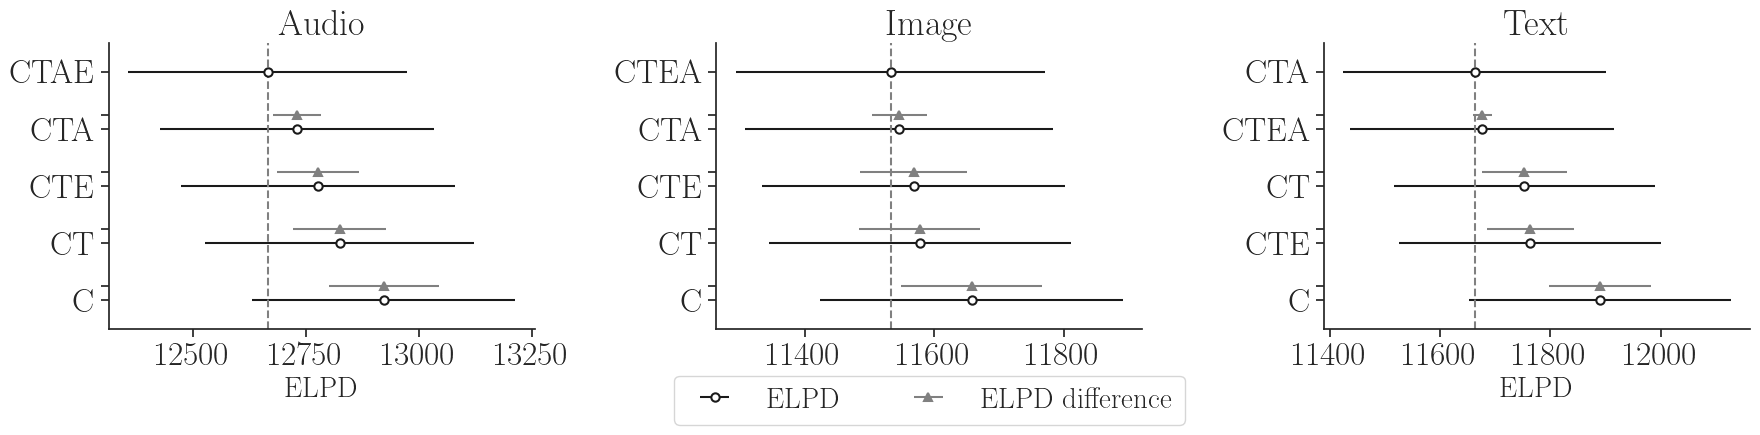

In [76]:
# def plot_loo(name, comp, legend = False, fontsize=32):
fig, axis = plt.subplots(figsize=(3*6, 5), ncols=3)

fontsize = 26

for i, (name, comp) in enumerate([("Audio", audio_compare), ("Image", image_compare), ("Text", text_compare)]):
    ax = axis[i]
    az.plot_compare(comp, ax=ax, legend=False, title=False)

    # remove all but last
    if i == 1:
        ax.legend(loc="center", bbox_to_anchor=(0.5, -.25), ncols=2, fontsize=fontsize - int(.2 * fontsize))
    else:
        ax.legend().remove()


    ax.set_ylabel(None)
    if i != 1:
        ax.set_xlabel("ELPD", fontsize=fontsize-int(.2 * fontsize))
    else:
        ax.set_xlabel("")

    y_labels = ax.get_yticklabels()

    def _labels(label):
        text = label.get_text().strip()
        return label

    ax.set_title(name, fontsize=fontsize)
    ax.set_yticklabels(list(map(_labels, y_labels)), fontsize=fontsize)
    # ax.set_xticklabels([])
    ax.set_xticklabels
    ax.tick_params(axis='both', which='major', labelsize="large")
    

fig.tight_layout()
fig.savefig(f"plot/loo_comparison.pdf")


In [9]:
audio = audio_compare[["rank", "loo"]].copy()
audio["type"] = "Audio"
audio["rank"] += 1

img = image_compare[["rank", "loo"]].copy()
img["type"] = "Image"
img["rank"] += 1

text = text_compare[["rank", "loo"]].copy()
text["type"] = "Text"
text["rank"] += 1

compare = pd.concat((audio, img, text))
pivot = compare.pivot(columns="type", values="loo")
pivot.columns.names = [""]
pivot = pivot.reindex(["base", "time", "edu", "age", "age edu"])
pivot.index = ["Country", "Country, Median Time", "Country, Median Time, Education", "Country, Median Time, Age", "Country, Median Time, Age, Education"]

print(pivot.style.to_latex())

KeyError: "['loo'] not in index"

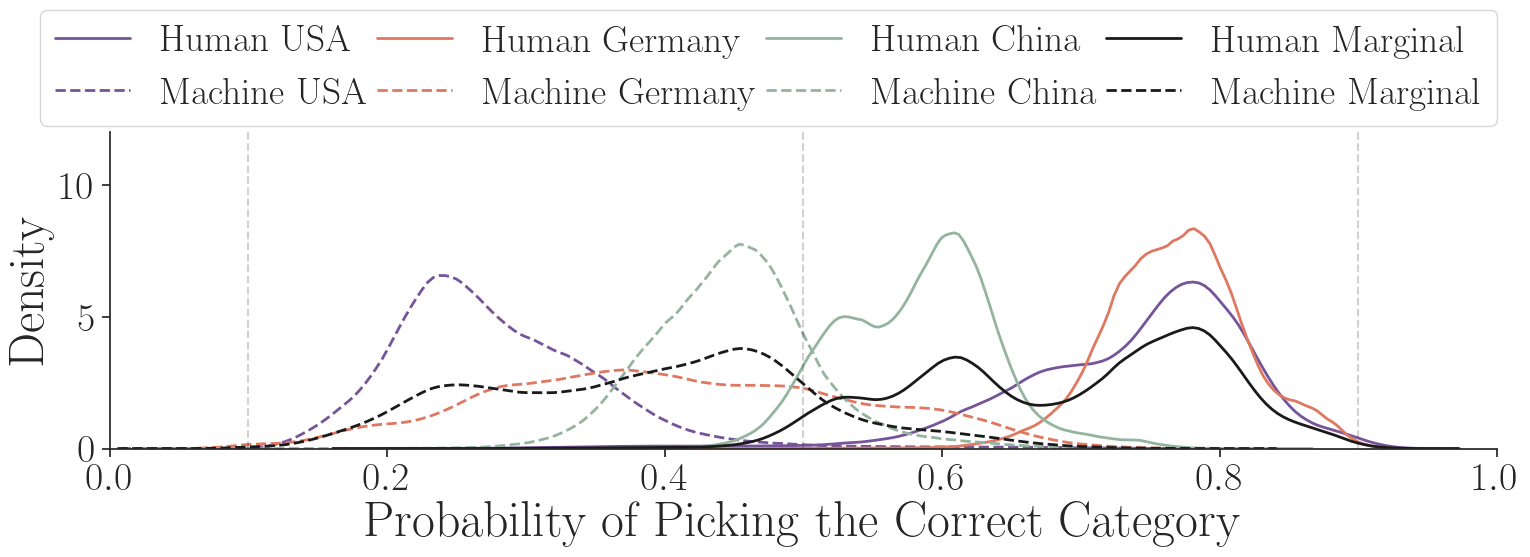

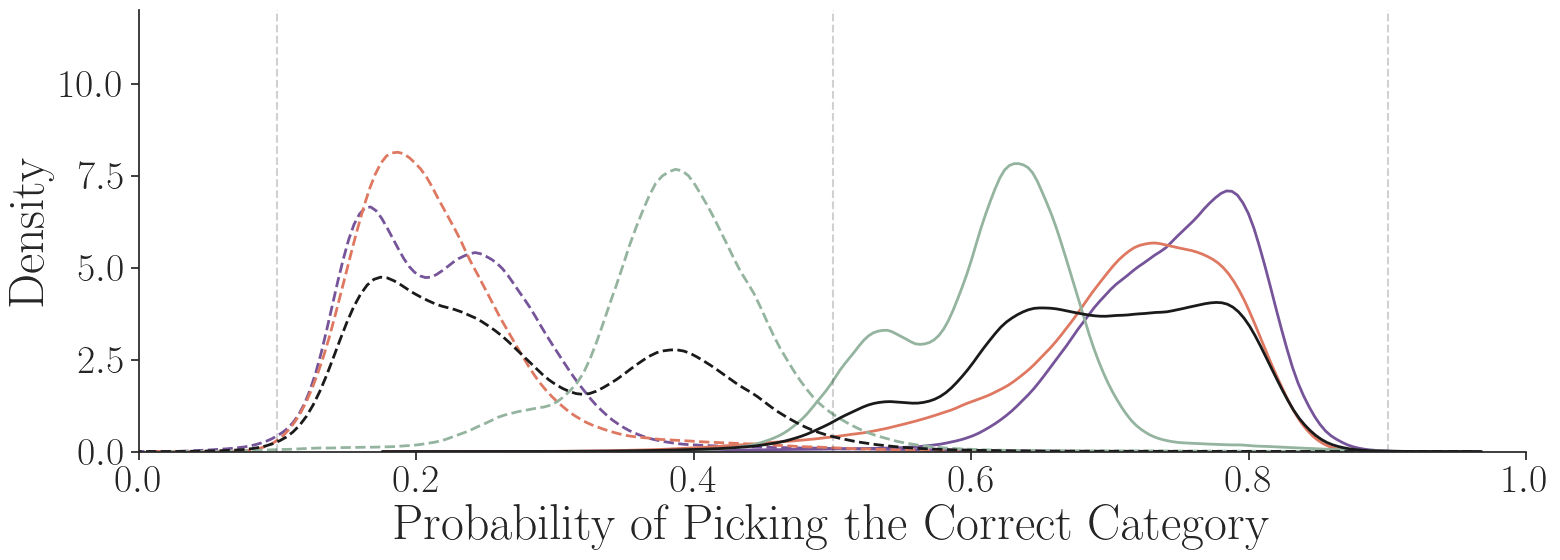

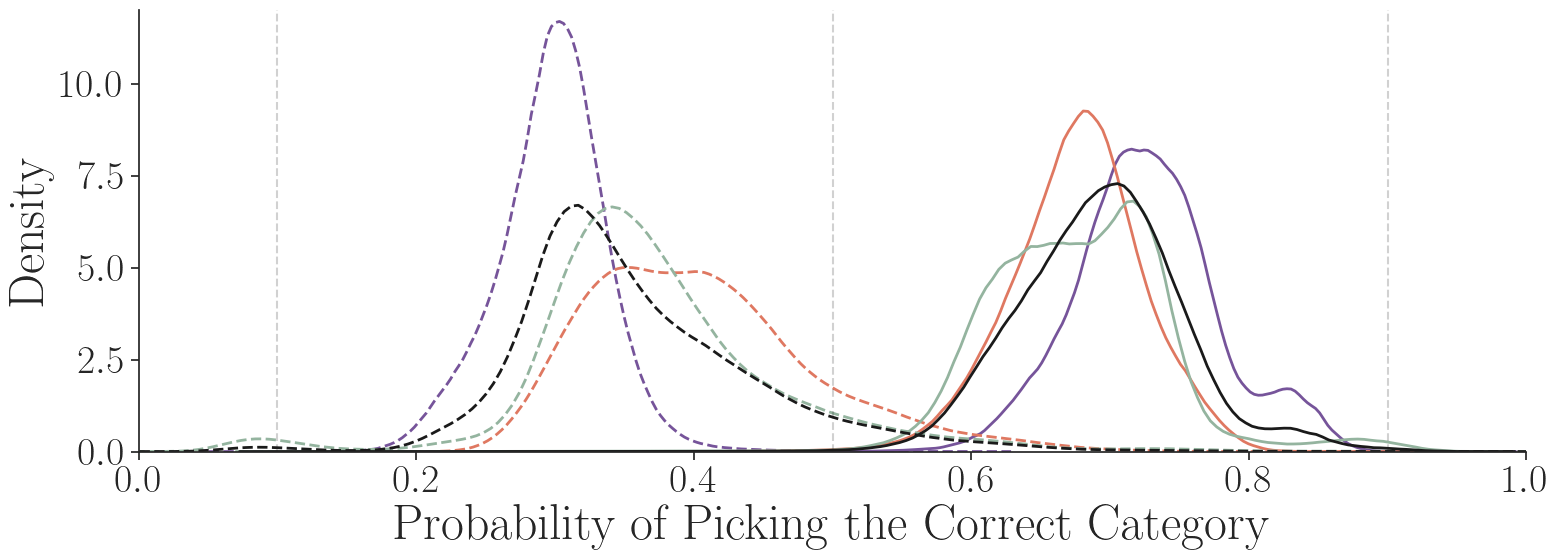

In [51]:
from scipy.special import expit as logistic
colors = plotting.COLORS[-1]

def plot_average(data, title):
    fig, ax = plt.subplots(figsize=(10,4), facecolor="white")

    country_data = data.constant_data.country_idx
    for idx, country in enumerate(["USA", "Germany", "China"]):
        user_ids = country_data == idx

        for media_type in ["Real", "Fake"]:
            sel_args = {
                "Country": country,
                "Type": media_type,
            }
            alpha = data.posterior.alpha.sel(sel_args)
            preds = [alpha]

            if "time" in data.posterior.data_vars:
                time_beta = data.posterior.time.sel(sel_args)
                time_data = data.constant_data.median_time[user_ids]

                preds.append((time_beta * time_data).mean("obs_idx"))

            if "edu" in data.posterior.data_vars:
                edu = data.posterior.edu.sel(sel_args).mean("Education")
                preds.append(edu)

            if "age" in data.posterior.data_vars:
                age = data.posterior.age.sel(sel_args).mean("Age")
                preds.append(age)

            posterior = logistic(np.asarray(preds).sum(axis=0))
            media_title = "Human" if media_type == "real" else "Machine"
            sn.kdeplot(posterior.flatten(), color=colors[idx], label=f"{media_title} {country}", ax=ax, linestyle="-" if media_type == "Real" else "--")

    ax.axvline(0.5, color="k", linestyle="--", alpha=.2)
    ax.axvline(0.1, color="k", linestyle="--", alpha=.2)
    ax.axvline(0.9, color="k", linestyle="--", alpha=.2)

    ax.set_xlabel(f"Probability of picking the correct category ({title})")
    ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=len(ax.lines))
    ax.set_xlim(-.1, 1.1)

    fig.tight_layout()

def plot_observed(data, title, per_country = True, legend = False, figsize=(16,6), fontsize = 36):
    fig, ax = plt.subplots(figsize=figsize, facecolor="white")

    country_data = data.constant_data.country_idx

    pi_real = logistic(data.posterior.pi_log_real.values)
    pi_fake = logistic(data.posterior.pi_log_fake.values)

    if per_country:
        for idx, country in enumerate(["USA", "Germany", "China"]):
            user_ids = country_data == idx
            sn.kdeplot(pi_real[:, :, user_ids].flatten(), color=colors[idx], label=f"Human {country}", ax=ax, linewidth=2)
            sn.kdeplot(pi_fake[:, :, user_ids].flatten(), color=colors[idx], label=f"Machine {country}", ax=ax, linestyle="--", linewidth=2)

    sn.kdeplot(pi_real.flatten(), color="k", label=f"Human Marginal", ax=ax, linewidth=2)
    sn.kdeplot(pi_fake.flatten(), color="k", label=f"Machine Marginal", ax=ax, linestyle="--", linewidth=2)

    ax.axvline(0.5, color="k", linestyle="--", alpha=.2)
    ax.axvline(0.1, color="k", linestyle="--", alpha=.2)
    ax.axvline(0.9, color="k", linestyle="--", alpha=.2)

    ax.set_xlabel("Probability of Picking the Correct Category", fontsize=fontsize)
    ax.set_ylabel("Density", fontsize=fontsize)


    if legend:
        if len(ax.lines) != 2:
            ax.legend(bbox_to_anchor=(-.05, 1.02, 1.05, 0.2), loc="lower left",
                        mode="expand", borderaxespad=0, ncol=4, fontsize=fontsize - int(0.25 * fontsize))
        else:
            ax.legend(bbox_to_anchor=(-.01, 1.02, 1, 0.2), loc="lower left",
                        mode="expand", borderaxespad=0, ncol=2)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 12)
    ax.tick_params(axis='both', which='major', labelsize="x-large")

    fig.tight_layout()
    fig.savefig(f"plot/{title.lower()}_posterior.pdf")

# plot_average(age_edu_audio_trace, "Audio")
# plot_average(age_edu_image_trace, "Image")
#plot_average(image_control_trace, "Image Control")
# plot_average(age_text_trace, "Text")
#plot_average(text_control_trace, "Text Control")

plot_observed(time_age_edu_audio_trace, "Audio", legend=True)
plot_observed(time_age_edu_image_trace, "Image")
plot_observed(time_age_text_trace, "Text")

In [107]:
user_kantar = pd.read_csv("./user_kantar.csv")
user_kantar.Device.value_counts(dropna=False), len(user_kantar)

(Laptop/Desktop    1345
 Mobile             825
 NaN                746
 Tablet              86
 Name: Device, dtype: int64,
 3002)

In [117]:
merged = pd.concat((audio_real_fake, image_real_fake, text_real_fake))
merged.device.value_counts(dropna=False), len(merged)

(Laptop/Desktop    913
 Mobile            584
 NaN               528
 Tablet             57
 Name: device, dtype: int64,
 2082)

In [ ]:
# Compute probability mass above 50%
audio_fake_data = age_edu_audio_trace.posterior.pi_fake
audio_fake_50 = ((audio_fake_data > .5).sum() / audio_fake_data.count() * 100).round(2)
print(audio_fake_50)

image_fake_data = age_edu_image_trace.posterior.pi_fake
image_fake_50 = ((image_fake_data > .5).sum() / image_fake_data.count() * 100).round(2)
print(image_fake_50)

text_fake_data = age_text_trace.posterior.pi_fake
text_fake_50 = ((text_fake_data > .5).sum() / text_fake_data.count() * 100).round(2)
print(text_fake_50)

# filter germany
audio_fake_data_filtered = audio_fake_data[:, :, age_edu_audio_trace.constant_data.country_idx != 1]
res = ((audio_fake_data_filtered > .5).sum() / audio_fake_data_filtered.count() * 100).round(2)
print(res)

<xarray.DataArray 'pi_fake' ()>
array(15.96)
<xarray.DataArray 'pi_fake' ()>
array(1.78)
<xarray.DataArray 'pi_fake' ()>
array(7.34)
<xarray.DataArray 'pi_fake' ()>
array(10.38)


In [ ]:
# filter germany
audio_fake_data = age_edu_audio_trace.posterior.pi_fake
audio_real_data = age_edu_audio_trace.posterior.pi_fake

audio_fake_china = audio_fake_data[:, :, age_edu_audio_trace.constant_data.country_idx == 1]
audio_real_china = audio_real_data[:, :, age_edu_audio_trace.constant_data.country_idx == 1]
res = audio_fake_china - 
print(res)

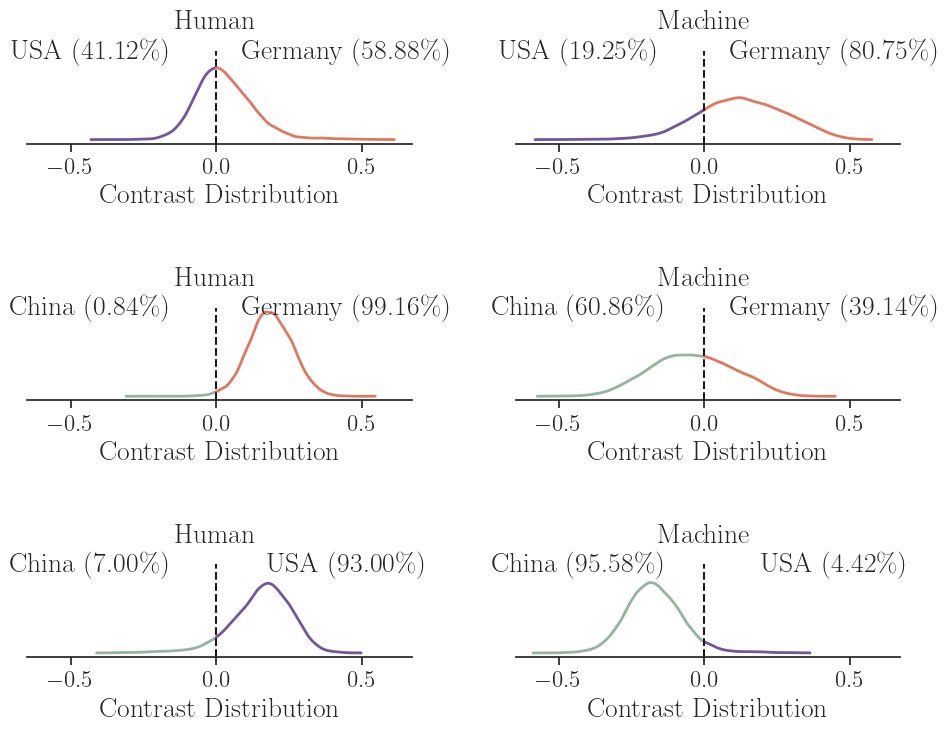

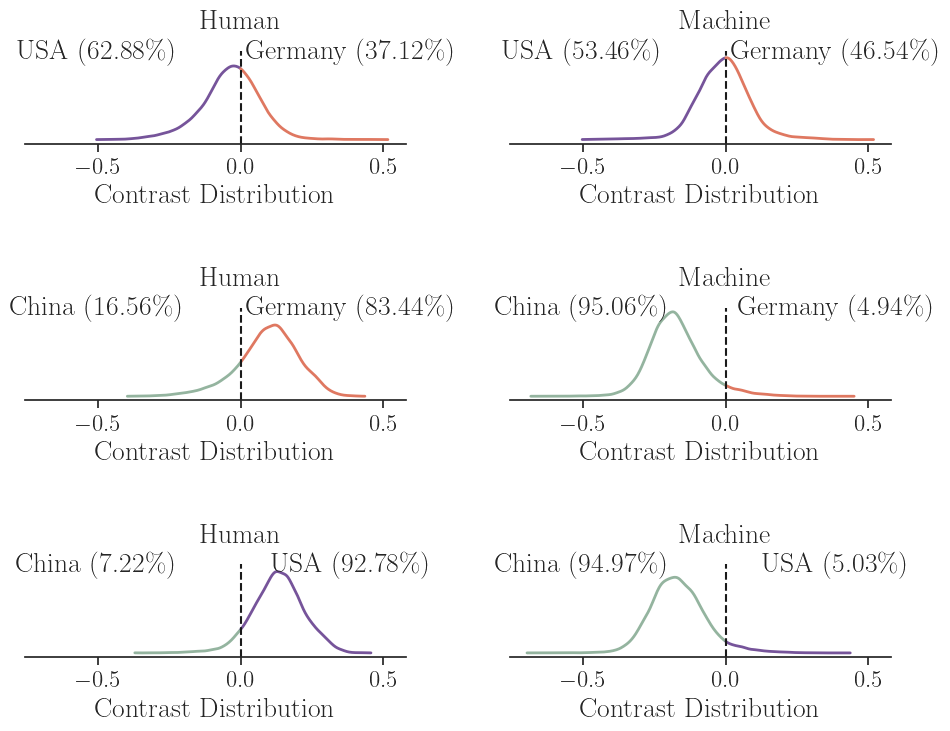

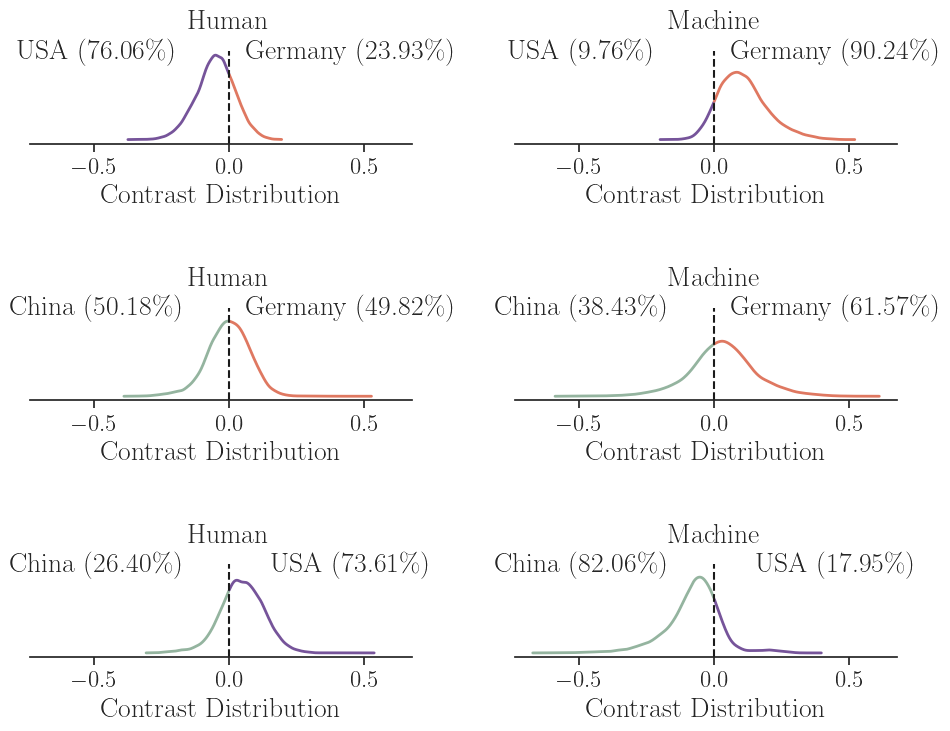

In [71]:
from scipy.stats import gaussian_kde
from typing import List
from typing import Tuple
from matplotlib.gridspec import GridSpec
from utils import COUNTRIES

COUNTRIES_TO_ID = dict(map(lambda x: (x[1], x[0]), enumerate(COUNTRIES)))

def plot_contrast(data, title: str, countries_to_compare: List[Tuple[str, List[str]]], kde_n: int = 5_00, figsize=(12, 10), samples_to_use: int = 20_000, fontsize: int = 20):
    fig = plt.figure(facecolor="white", figsize=figsize)
    amount_of_compares = sum(map(lambda x: len(x[1]), countries_to_compare))
    gs = GridSpec(amount_of_compares, 2, figure=fig)
    cur_ax = None

    order = []
    percentages = []
    i = 0

    country_data = data.constant_data.country_idx

    for ca, compare in countries_to_compare:
        for cb in compare:
            for j, media_type in enumerate(["real", "fake"]):
                ax = fig.add_subplot(gs[i, j], sharey=cur_ax, sharex=cur_ax)
                cur_ax = ax

                # calculate values
                a_idx = country_data == COUNTRIES_TO_ID[ca]
                b_idx = country_data == COUNTRIES_TO_ID[cb]


                dca = logistic(data.posterior[f"pi_log_{media_type}"][:, :, a_idx].values.flatten())
                dcb = logistic(data.posterior[f"pi_log_{media_type}"][:, :, b_idx].values.flatten())

                # sample 10k each
                dca = rng.choice(dca, samples_to_use, replace=False)
                dcb = rng.choice(dcb, samples_to_use, replace=False)

                contrast = (dca - dcb).flatten()

                # calculate density
                x_array = np.linspace(contrast.min(), contrast.max(), kde_n)
                kde = gaussian_kde(contrast)
                density = kde(x_array)

                lower = x_array < 0.
                ax.plot(x_array[lower], density[lower], color=plotting.COUNTRY_COLORS[cb], linewidth=2)
                ax.plot(x_array[~lower], density[~lower], color=plotting.COUNTRY_COLORS[ca], linewidth=2)

                order.append((ca, cb))

                percentage = sum(contrast < 0) / len(contrast)
                percentages.append((1 - percentage, percentage))

                ax.set_xlabel(f"Contrast Distribution", fontsize=fontsize)

                # if j == 0:
                #     ax.set_ylabel(f"{ca} - {cb}")

                ax.spines['left'].set_visible(False)
                ax.set_yticks([])
                ax.set_yticklabels([])

                ax.axvline(0, color="k", linestyle="--")
                ax.tick_params(axis='both', which='major', labelsize="small")

            i += 1

    for i, ax in enumerate(fig.get_axes()):
        ca, cb = order[i]
        lower, higher = percentages[i]

        x_low, x_high = ax.get_xlim()
        _, y_high = ax.get_ylim()

        media_type = "Human" if i % 2 == 0 else "Machine"
        ax.text(0, y_high + (y_high / 3), media_type, rotation=0, va="center", ha="center", fontsize=fontsize)
        ax.text(x_high - (x_high / 3), y_high, f"{ca} ({lower*100:.2f}\%)", va="center", ha="center", fontsize=fontsize)
        ax.text(x_low + abs((x_low / 3)), y_high, f"{cb} ({higher*100:.2f}\%)", va="center", ha="center", fontsize=fontsize)

    fig.tight_layout()
    fig.savefig(f"plot/{title}_contrast.pdf")


plot_contrast(
    data=time_age_edu_audio_trace, 
    title="audio",
    countries_to_compare=[
        ("Germany", ["USA", "China"]),
        ("USA", ["China"]),
    ],
    figsize=(10, 8)
)

plot_contrast(
    data=time_age_edu_image_trace, 
    title="image",
    countries_to_compare=[
        ("Germany", ["USA", "China"]),
        ("USA", ["China"]),
    ],
    figsize=(10, 8)
)

plot_contrast(
    data=time_age_text_trace, 
    title="text",
    countries_to_compare=[
        ("Germany", ["USA", "China"]),
        ("USA", ["China"]),
    ],
    figsize=(10, 8)
)

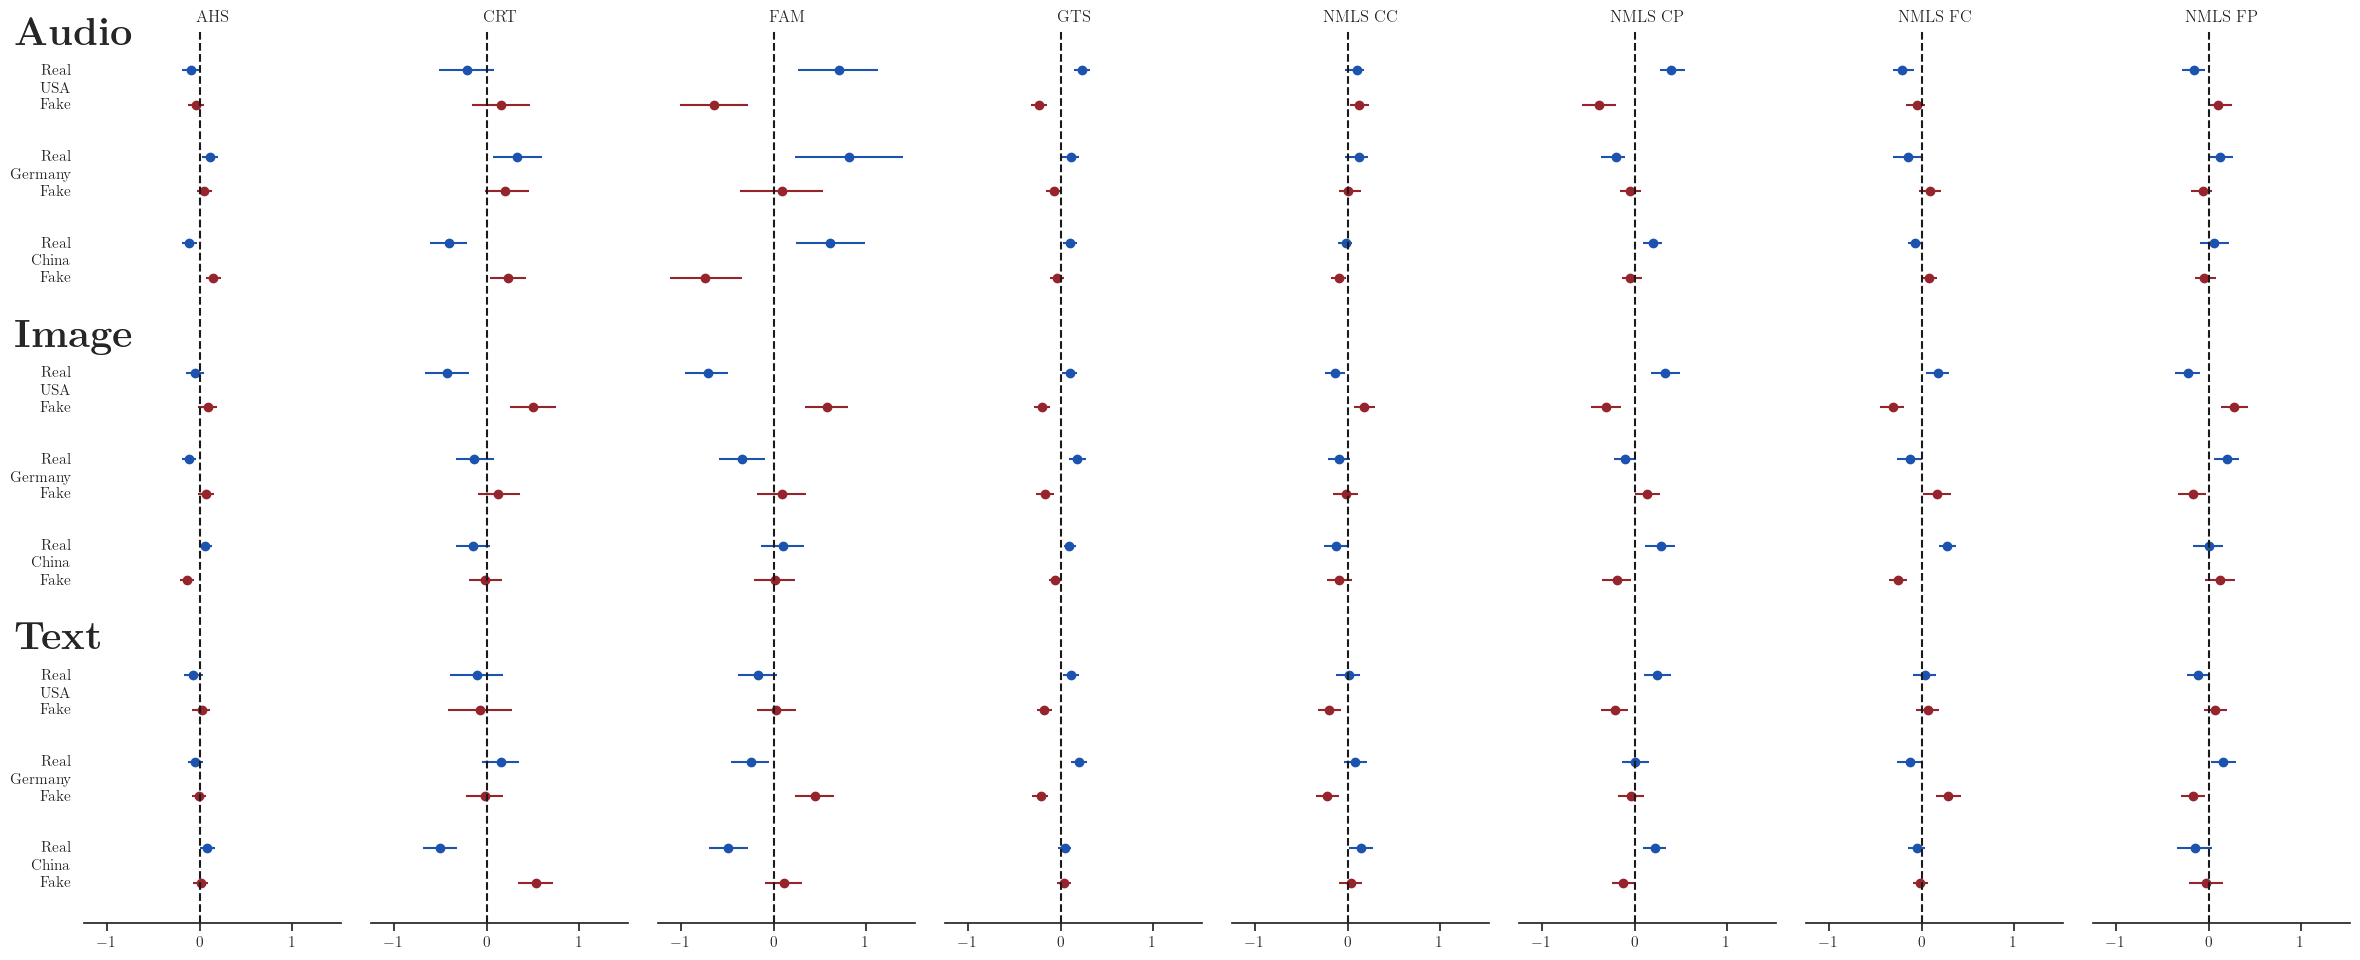

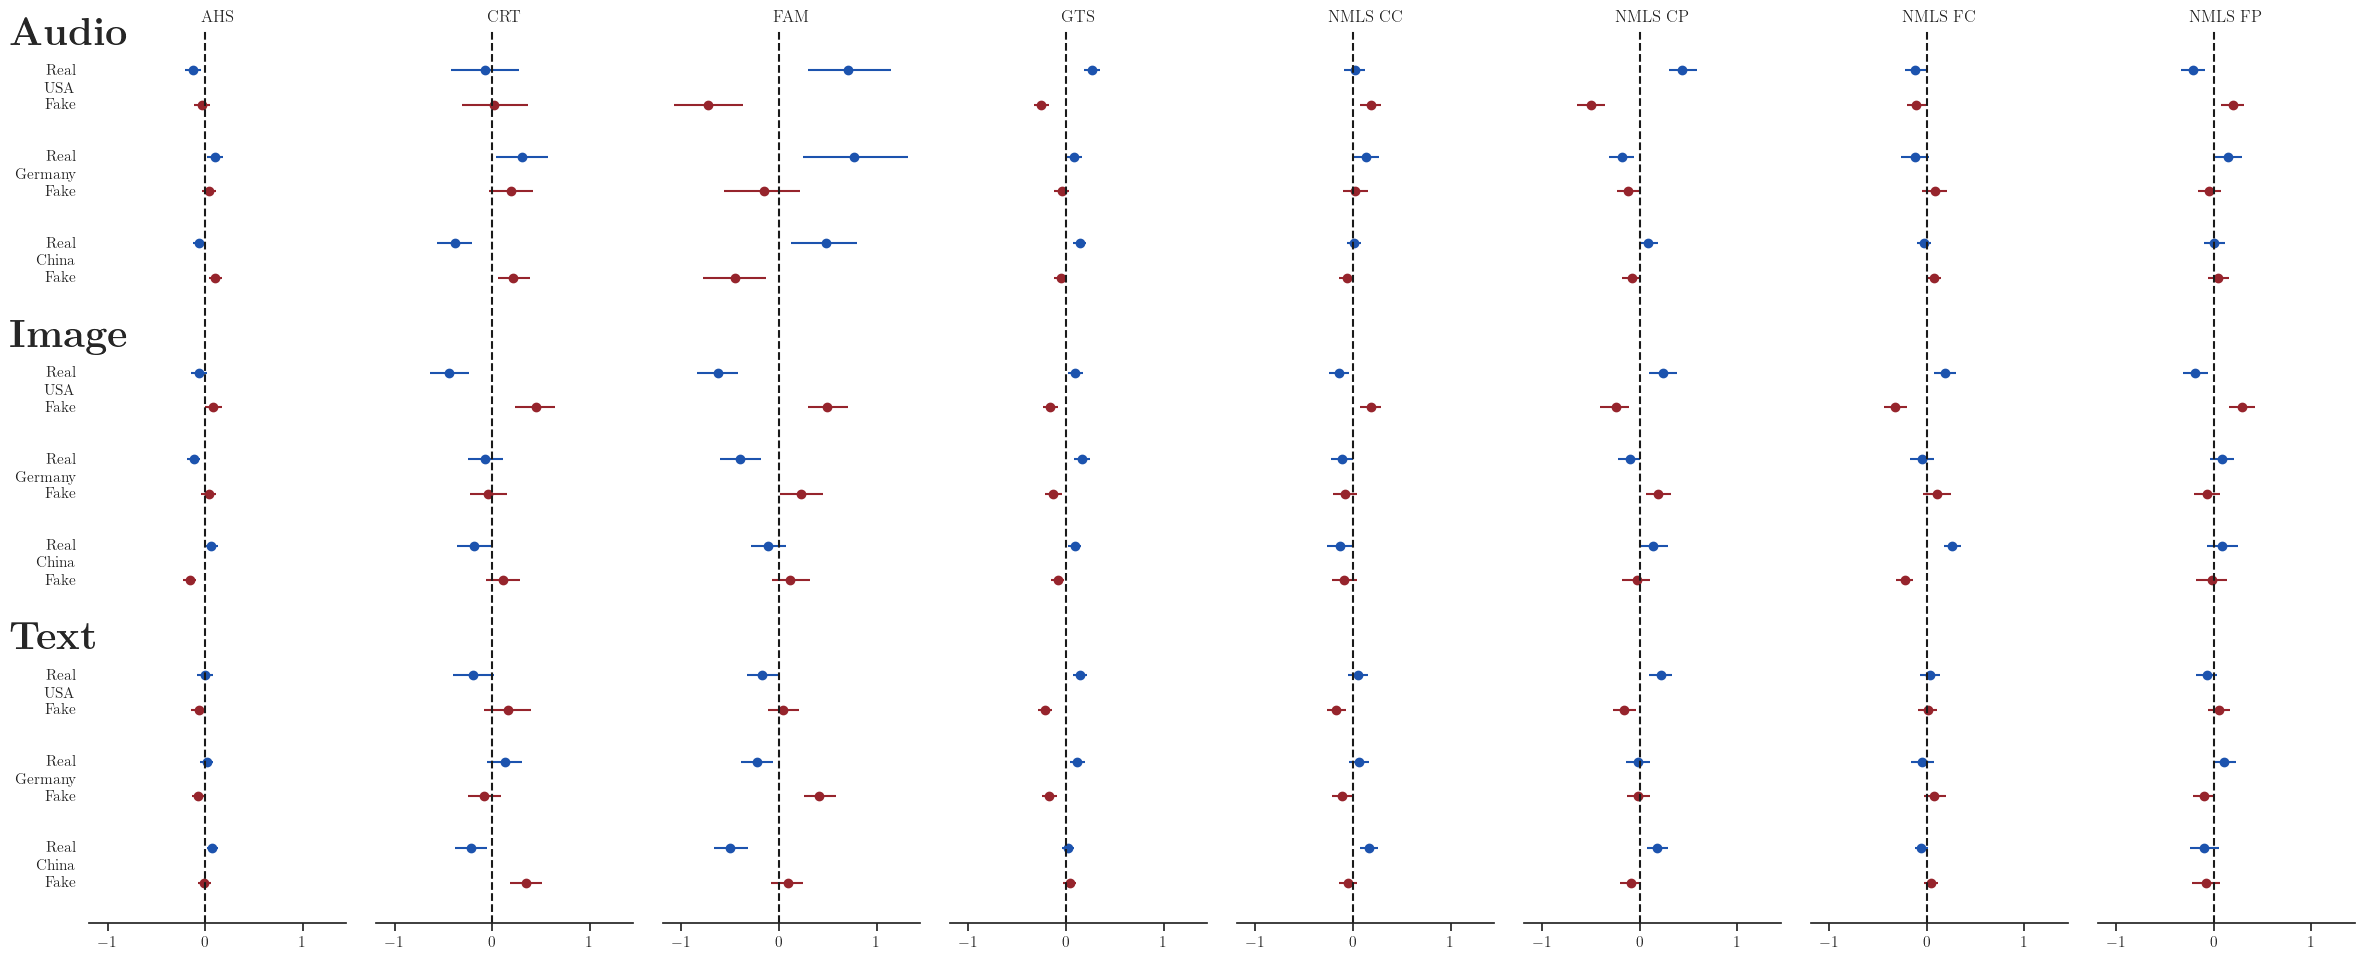

In [35]:
from collections import deque
from math import comb

from matplotlib.gridspec import GridSpec


def _compute_combinations(post_data):
    dims = list(filter(lambda x: x not in["chain", "draw"], post_data.dims))
    combinations = deque([()])
    for dim in dims:
        for _ in range(len(combinations)):
            cur = combinations.popleft()
            for d in post_data.coords[dim]:
                combinations.append((*cur, (dim, str(d.values))))

    return combinations

def extract_trace_data(traces):
    extracted = []
    for trace in traces:
        predictors = [var for var in trace.posterior.data_vars if "beta_" in var]

        for pred in predictors:
            if "PO" in pred:
                continue 

            post_data = trace.posterior[pred]
            combinations = _compute_combinations(post_data)

            for comb in combinations:
                sel = dict(comb)
                sel_data = post_data.sel(sel)

                mean = sel_data.mean().values
                low, high = az.hdi(sel_data)[pred].values
                if mean > 0:
                    percentage = (sel_data > 0.).sum() / sel_data.count()
                else:
                    percentage = (sel_data < 0.).sum() / sel_data.count()

                series = pd.Series(
                    [pred.replace("beta_", "").replace("_", " "), *list(sel.values()), mean, low, high, percentage.values],
                    index=["name", *list(sel.keys()), "mean", "low", "high", "percentage"],
                )
                extracted.append(series)

    return pd.concat(extracted, axis=1).transpose()


def plot_forest(paths, titles, jitter=.1, spacer=.5):
    # extract predictors
    predictors = []
    for path, title in zip(paths, titles):
        traces = [az.from_netcdf(path) for path in path.glob("*.nc")]
        extracted = extract_trace_data(traces)
        extracted["category"] = [title] * len(extracted)
        
        predictors.append(extracted)

    predictors = pd.concat(predictors, axis=0)

    n_predictors = predictors.name.nunique()
   
    fig = plt.figure(facecolor="white", figsize=(3 * n_predictors, 10))
    gs = GridSpec(1, n_predictors, figure=fig)
    cur_ax = None

    colors = plotting.DIVERGING_COLORS[-1]
    countries = ["USA", "Germany", "China"]

    for i, pred in enumerate(sorted(predictors.name.unique())):
        data = predictors[predictors.name == pred]
        ax = fig.add_subplot(gs[0, i], sharex=cur_ax)
        cur_ax = ax

        y = 0
        ticks_and_labels = {}
        for cat in titles:
            if i == 0:
                ax.text(-2., y + 2.5*jitter, f"$\\bf{{{cat}}}$", fontsize="x-large")
            for country in countries:
                for j, (jit, media_type) in enumerate([(jitter, "Real"), (-jitter, "Fake")]):
                    d = data[(data.Country == country) & (data.Type == media_type) & (data.category == cat)]

                    point = y + jit
                    ticks_and_labels[point] = media_type

                    ax.scatter(d["mean"], point, color=colors[j], label=media_type)
                    ax.hlines(point, d["low"], d["high"], color=colors[j])

                ticks_and_labels[y] = f"{country}        "
                y -= spacer

            y -= spacer * .5

        # remove spines and ticks
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('none')
        ax.set_title(pred)

        if i == 0:
            ticks, ticklabels = list(zip(*ticks_and_labels.items()))
            ax.set_yticks(ticks)
            ax.set_yticklabels(ticklabels)
        else:
            ax.set_yticks([])
            ax.set_yticklabels([])

        ax.axvline(0, color="k", linestyle="--")


    # fig.suptitle(title, fontsize="x-large")
    fig.tight_layout()
    return predictors

predictors = plot_forest(paths=[Path("traces/real_fake/half-median/fixed_country/audio/"), Path("traces/real_fake/half-median/fixed_country//image/"), Path("traces/real_fake/half-median/fixed_country//text/")], 
    titles=["Audio", "Image", "Text"]);
predictors = plot_forest(paths=[Path("traces/real_fake/interval/fixed_country/audio/"), Path("traces/real_fake/interval/fixed_country//image/"), Path("traces/real_fake/interval/fixed_country//text/")], 
    titles=["Audio", "Image", "Text"]);

| 30 | AHS     | Fake   | USA       | -0.156568  | -0.258155   | -0.0564185  |     0.998125 | Audio      |
| 32 | AHS     | Fake   | China     |  0.208581  |  0.108707   |  0.308784   |     1        | Audio      |
| 12 | AHS     | Fake   | USA       | -0.0947505 | -0.18897    |  0.00598653 |     0.9645   | Text       |
| 13 | AHS     | Fake   | Germany   | -0.0819627 | -0.153948   | -0.00901543 |     0.984    | Text       |

| 34 | AHS     | Real   | Germany   |  0.109906  |  0.0169259  |  0.197966   |     0.9885   | Audio      |
| 35 | AHS     | Real   | China     | -0.159182  | -0.260292   | -0.0584061  |     0.99875  | Audio      |
| 34 | AHS     | Real   | Germany   | -0.0853075 | -0.161376   | -0.00934274 |     0.982125 | Image      |
| 17 | AHS     | Real   | China     |  0.127215  |  0.0342841  |  0.210942   |     0.996625 | Text       |

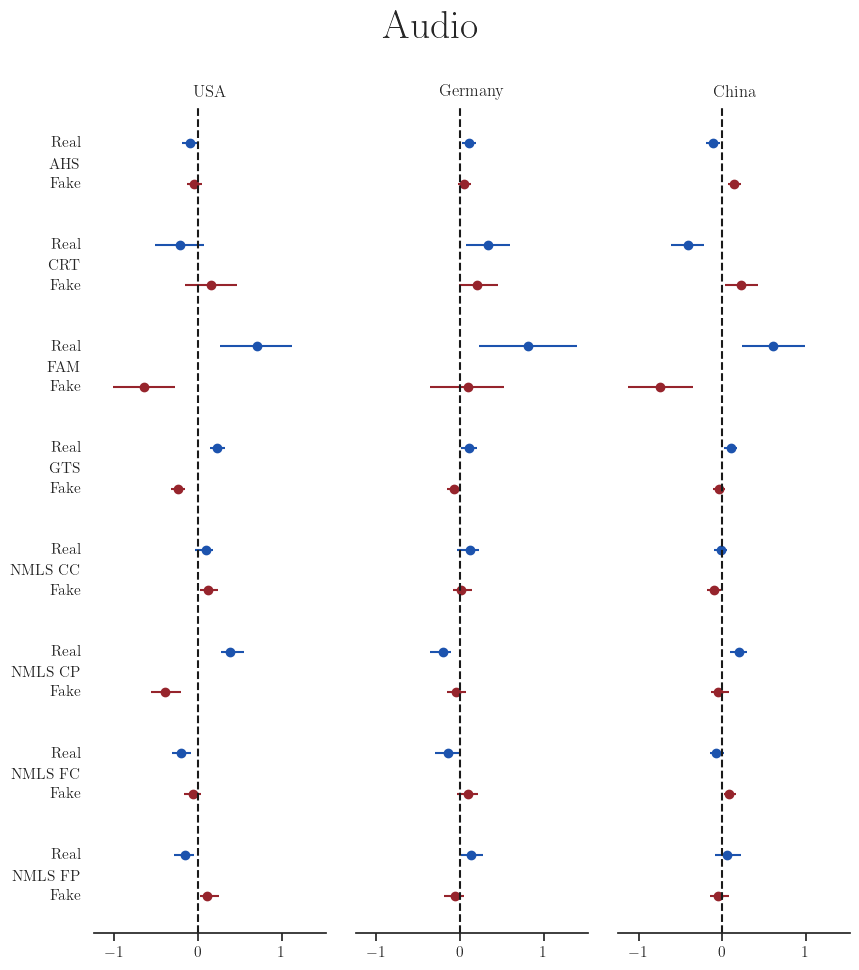

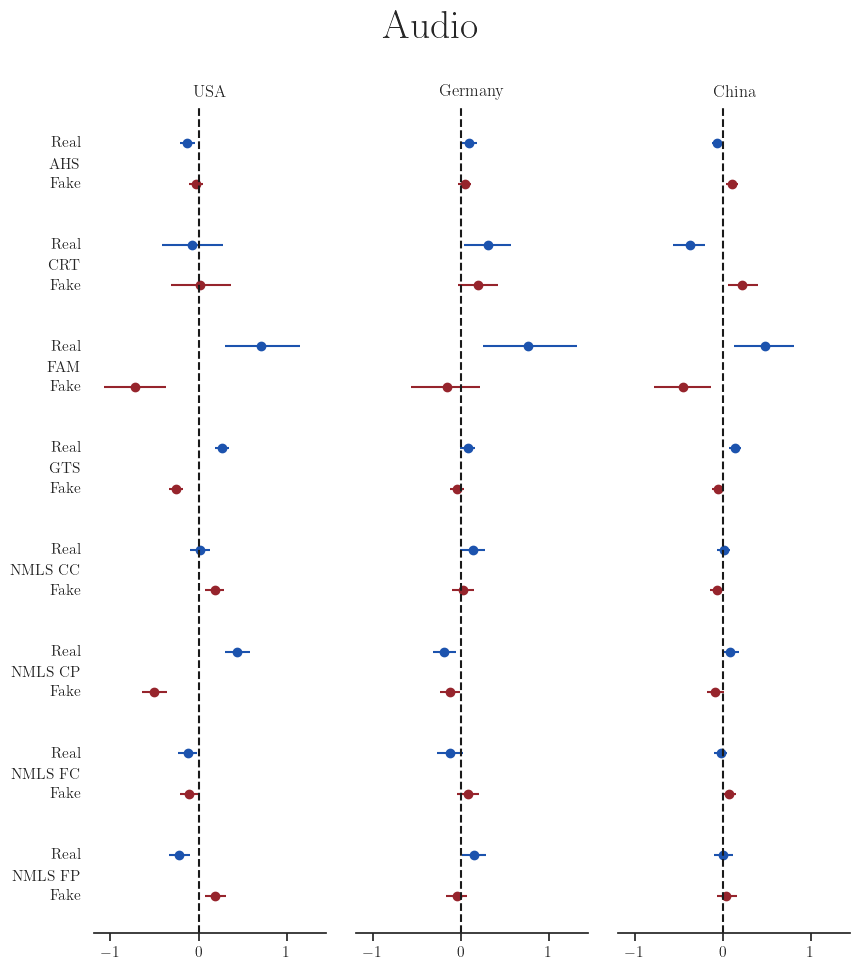

In [36]:
def plot_forest_single_category(path, title, jitter=.1, spacer=.5):
    # extract predictors
    traces = [az.from_netcdf(path) for path in path.glob("*.nc")]
    predictors = extract_trace_data(traces)

    n_predictors = predictors.name.nunique()
   
    fig = plt.figure(facecolor="white", figsize=(3 * 3, 10))
    gs = GridSpec(1, 3, figure=fig)
    cur_ax = None

    colors = plotting.DIVERGING_COLORS[-1]
    countries = ["USA", "Germany", "China"]

    for i, country in enumerate(countries):
        data = predictors[predictors.Country == country]
        ax = fig.add_subplot(gs[0, i], sharex=cur_ax)
        cur_ax = ax

        y = 0
        ticks_and_labels = {}

        for pred in sorted(predictors.name.unique()):
            for j, (jit, media_type) in enumerate([(jitter, "Real"), (-jitter, "Fake")]):
                d = data[(data.Type == media_type) & (data.name == pred)]

                point = y + jit
                ticks_and_labels[point] = media_type

                ax.scatter(d["mean"], point, color=colors[j], label=media_type)
                ax.hlines(point, d["low"], d["high"], color=colors[j])

            ticks_and_labels[y] = f"{pred}" + " " * 10
            y -= spacer


        # remove spines and ticks
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('none')
        ax.set_title(country)

        if i == 0:
            ticks, ticklabels = list(zip(*ticks_and_labels.items()))
            ax.set_yticks(ticks)
            ax.set_yticklabels(ticklabels)
        else:
            ax.set_yticks([])
            ax.set_yticklabels([])

        ax.axvline(0, color="k", linestyle="--")


    fig.suptitle(title, fontsize="x-large")
    fig.tight_layout()
    return predictors

audio_predictors = plot_forest_single_category(path=Path("traces/real_fake/half-median/fixed_country/audio/"), title="Audio")
audio_predictors = plot_forest_single_category(path=Path("traces/real_fake/interval/fixed_country/audio/"), title="Audio")
# image_predictors = plot_forest_single_category(path=Path("traces/real_fake/half-median/fixed_country/image/"), title="Image")
# image_predictors = plot_forest_single_category(path=Path("traces/real_fake/interval/fixed_country/image/"), title="Image")
# text_predictors = plot_forest_single_category(path=Path("traces/real_fake/half-median/fixed_country/text/"), title="Text");
# text_predictors = plot_forest_single_category(path=Path("traces/real_fake/interval/fixed_country/text/"), title="Text");

In [38]:
    fig = plt.figure(figsize=(18, 9))
audio_predictors = plot_forest_single_category(path=Path("traces/real_fake/combinations/fixed/audio/"), title="Audio")

AttributeError: 'DataFrame' object has no attribute 'Country'

<Figure size 900x1000 with 0 Axes>

In [13]:
data = time_age_edu_audio_trace
data.posterior.age.sel({"Country":"USA"})[:,:,:,1]

<xarray.DataArray 'age' (chain: 4, draw: 2000, Type: 2)>
array([[[-0.33978443, -0.31109829],
        [-0.09475244, -0.05859619],
        [-0.5632212 ,  0.32567204],
        ...,
        [-0.71034704,  0.28347526],
        [-0.35029007,  0.19072441],
        [-0.98624558, -0.6283547 ]],

       [[ 0.17037955, -0.54935982],
        [ 0.27088392,  0.00815835],
        [ 0.49382347, -0.64359689],
        ...,
        [-0.4840653 , -0.48597775],
        [ 0.18452842, -0.74874482],
        [-0.53165839, -0.51800637]],

       [[-0.56710477, -0.29145938],
        [-0.25473253,  0.10804766],
        [ 0.31137296, -0.11374442],
        ...,
        [ 0.17094012, -0.49261616],
        [-0.72039329,  0.06746125],
        [-0.37637259,  0.06530176]],

       [[ 0.03137092,  0.24559452],
        [-0.20871308,  0.20157705],
        [-0.32751614, -0.86809475],
        ...,
        [-0.62006671,  0.83369998],
        [-0.61177184,  0.22951313],
        [-0.59493856,  1.49891714]]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
    Country  <U3 'USA'
    Age      <U5 '20-24'
  * Type     (Type) object 'Fake' 'Real'

In [16]:
text_trace = az.from_netcdf("traces/accuracy/interval/demographics/text/time_age_edu.nc").load()
text_trace.posterior.age.sel({"Country": "USA"})

<xarray.DataArray 'age' (chain: 4, draw: 2000, Age: 17)>
array([[[-0.07415156,  0.01746591,  0.03522488, ..., -0.01418095,
          0.02233344, -0.00361579],
        [ 0.00882789, -0.03856364, -0.04195804, ...,  0.05620428,
         -0.00461664,  0.01700915],
        [ 0.06961292,  0.05084336,  0.07493388, ...,  0.16479064,
          0.1177148 ,  0.11494486],
        ...,
        [-0.00911139, -0.01775125, -0.01880707, ..., -0.00748325,
         -0.03416746,  0.00626396],
        [ 0.03328822,  0.0396315 ,  0.01460615, ..., -0.00541588,
          0.02565691, -0.00724604],
        [-0.0605035 , -0.07410707, -0.00237557, ..., -0.0207673 ,
         -0.100071  , -0.01002993]],

       [[-0.12185052, -0.11747231, -0.16156658, ..., -0.16511949,
         -0.08794934, -0.17467811],
        [-0.05377058, -0.05817645, -0.02223489, ..., -0.04133626,
         -0.02469104, -0.05655688],
        [-0.01328942, -0.07765121,  0.06288265, ..., -0.07440515,
          0.02167814, -0.04311275],
...
        [ 0.09488511,  0.12909306,  0.08224488, ...,  0.1045692 ,
          0.09386486,  0.12543379],
        [ 0.05188348,  0.07065427,  0.06341035, ...,  0.07400089,
          0.05829525,  0.10235452],
        [-0.00927536,  0.02270859,  0.08645249, ...,  0.10846045,
          0.13882069,  0.15701051]],

       [[-0.00713864, -0.001629  , -0.00974803, ..., -0.00452152,
          0.00153647, -0.00068505],
        [-0.01940491, -0.02881342, -0.07670528, ...,  0.03634068,
          0.04807847,  0.0219289 ],
        [-0.01382659, -0.00972349, -0.01265799, ..., -0.00329445,
          0.04200596,  0.01101887],
        ...,
        [ 0.0616233 , -0.04633106, -0.01589827, ...,  0.0548315 ,
         -0.07601648, -0.1306999 ],
        [ 0.1352606 ,  0.18513375,  0.20544721, ...,  0.12541691,
          0.24416317,  0.20594123],
        [-0.07048558, -0.02784039, -0.0025415 , ..., -0.02726534,
         -0.06123596,  0.00444775]]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
    Country  <U3 'USA'
  * Age      (Age) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16

Audio USA
ConfidenceInterval(low=-0.5768146677681467, high=0.31032630126951216) ConfidenceInterval(low=0.2916372268452532, high=1.2501367086670174) non significant
50.62% -> 50.69%
Audio Germany
ConfidenceInterval(low=-1.0477960732165208, high=-0.9852941176470591) ConfidenceInterval(low=-3.4419042307615615e-09, high=7.156547645406652e-15) significant
68.58% -> 50.99%
Audio China
ConfidenceInterval(low=-0.9256891474251787, high=0.009386416582834567) ConfidenceInterval(low=-0.684145741673451, high=0.214703817649819) non significant
52.49% -> 51.15%
Image USA
ConfidenceInterval(low=-0.9290112340325868, high=-0.46453374484805376) ConfidenceInterval(low=-0.27746833827891865, high=0.02324006100206459) non significant
49.40% -> 48.17%
Image Germany
ConfidenceInterval(low=-1.0900510114095265, high=-0.6670130086556658) ConfidenceInterval(low=-0.02821167916447975, high=0.00014137328395790382) significant
47.23% -> 44.16%
Image China
ConfidenceInterval(low=0.6898011643201765, high=1.1348328150310

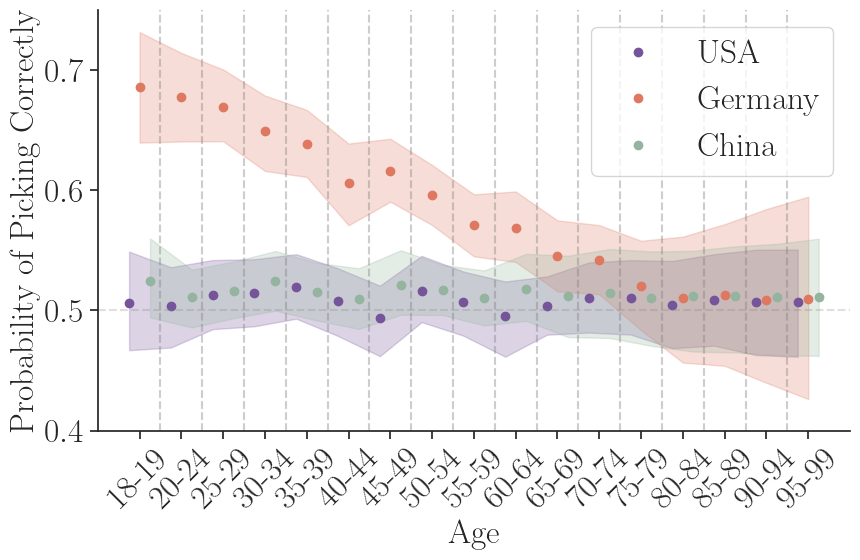

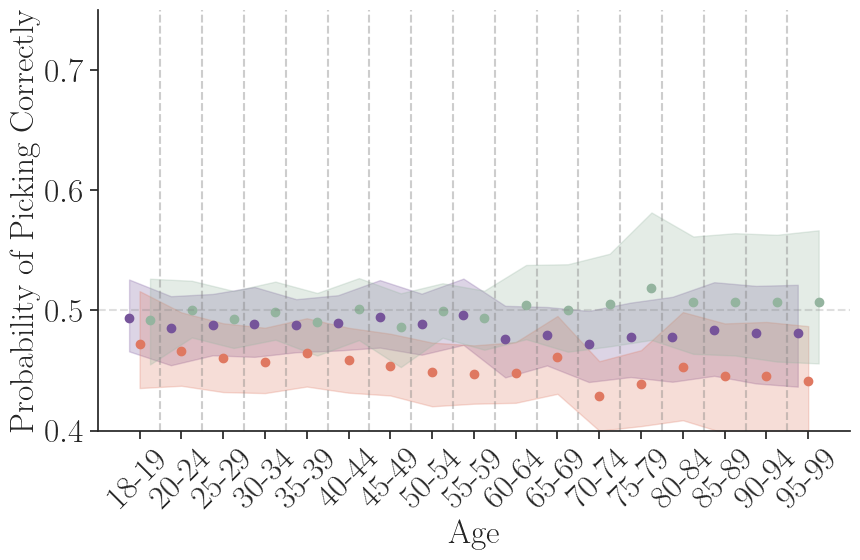

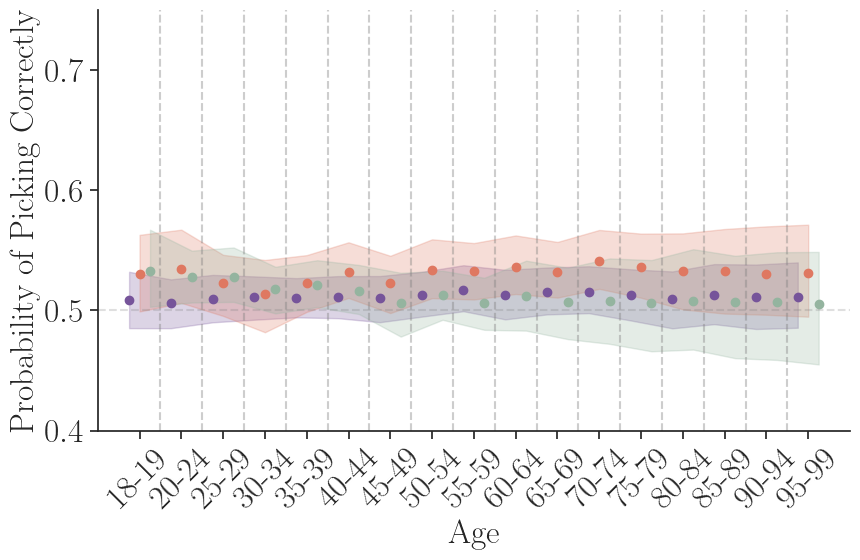

In [51]:
import re
from scipy.stats import spearmanr, bootstrap

def corr_stat(x,y,*args, **kwargs):
    return spearmanr(x, y, *args, **kwargs)[0]

def corr_p(x,y, *args, **kwargs):
    return spearmanr(x, y, *args, **kwargs)[1]


def plot_age_predictor(data, title, figsize=(9, 6), plot_mean: bool = True, legend: bool = False):
    fig, ax = plt.subplots(figsize=figsize, facecolor="white")
    n_age_bins = len(data.posterior.coords["Age"])

    colors = plotting.COLORS[-1]
    country_offses = [-.25, 0, .25]

    for cidx, country in enumerate(["USA", "Germany", "China"]):
        sel_args = {
            "Country": country,
        }
        alpha = data.posterior.alpha_c.sel(sel_args)
        preds = [alpha]

        # include other predictors mean
        if "edu" in data.posterior.data_vars:
            edu = data.posterior.edu.sel(sel_args).mean(dim="Education")

            preds.append(edu)

        # include other predictors mean
        if "time" in data.posterior.data_vars:
            time = data.posterior.time.sel(sel_args)

            idx = data.constant_data.country_idx == cidx
            median_median_country = data.constant_data.median_time[idx].median(
            )
            preds.append(median_median_country * time)

        # calculate age specific offset
        posterior = []

        for i in range(n_age_bins):
            log_odds = data.posterior.age.sel(
                sel_args)[:, :, i] + np.sum(preds, axis=0)
            posterior.append(logistic(log_odds))

        labels = {}
        points = []
        means = []
        lows = []
        highs = []

        color = colors[cidx]

        for i in range(n_age_bins):
            post_data = posterior[i]
            mean = post_data.mean().values
            low, high = az.hdi(post_data).age.values

            point = i + 1
            labels[point] = utils.AGE_LABELS[i]
            means.append(mean)
            lows.append(low)
            highs.append(high)

            offset_point = point + country_offses[cidx]
            if i == 0:
                ax.plot(offset_point, mean,  "o",
                        color=color, label=country)
            else:
                ax.plot(offset_point, mean,  "o", color=color)

            # ax.vlines(offset_point, low, high, color=color, linewidth=1)

            points.append(offset_point)

            if i < n_age_bins - 1:
                ax.axvline(point + .5, color="grey", linestyle="--", alpha=.15)

        ax.fill_between(points, lows, highs, color=color, alpha=0.25)

        # technically we set this twitce, but its the same anyway
        ticks, labels = list(zip(*labels.items()))
        r_bootstrap = bootstrap(
            (np.arange(1, len(means) + 1), means),
            statistic=corr_stat,
            n_resamples=1000,
            confidence_level=0.95,
            paired=True,
            method="basic",
        )

        p_bootstrap = bootstrap(
            (np.arange(1, len(means) + 1), means),
            statistic=corr_p,
            n_resamples=1000,
            confidence_level=0.95,
            paired=True,
            method="basic",
        )

        print(title, country)
        print(
            f"{r_bootstrap.confidence_interval} {p_bootstrap.confidence_interval} {'significant' if p_bootstrap.confidence_interval.high < 0.01 else 'non significant'}")
        print(
            f"{means[0]:.2%} -> {means[-1]:.2%}")

    labels = list(labels)
    labels[0] = re.sub("15", "18", labels[0]) 
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)

    ax.set_ylim((.4, .75))
    ax.set_xlim((0, n_age_bins + 1))
    # ax.set_title(title, fontsize="large")
    ax.tick_params(labelsize="large")
    ax.axhline(.5, color="grey", linestyle="--", alpha=.25)

    ax.set_ylabel("Probability of Picking Correctly", fontsize="large")
    ax.set_xlabel("Age",
                  fontsize="large")

    if legend:
        ax.legend(fontsize="large")

    fig.tight_layout()
    fig.savefig(f"plot/{title.lower()}_age_posterior.pdf")


audio_trace = az.from_netcdf(
    "traces/accuracy/interval/demographics/audio/time_age_edu.nc").load()
plot_age_predictor(audio_trace, "Audio", legend=True)

image_trace = az.from_netcdf(
    "traces/accuracy/interval/demographics/image/time_age_edu.nc").load()
plot_age_predictor(image_trace, "Image")

text_trace = az.from_netcdf(
    "traces/accuracy/interval/demographics/text/time_age.nc").load()
plot_age_predictor(text_trace, "Text")


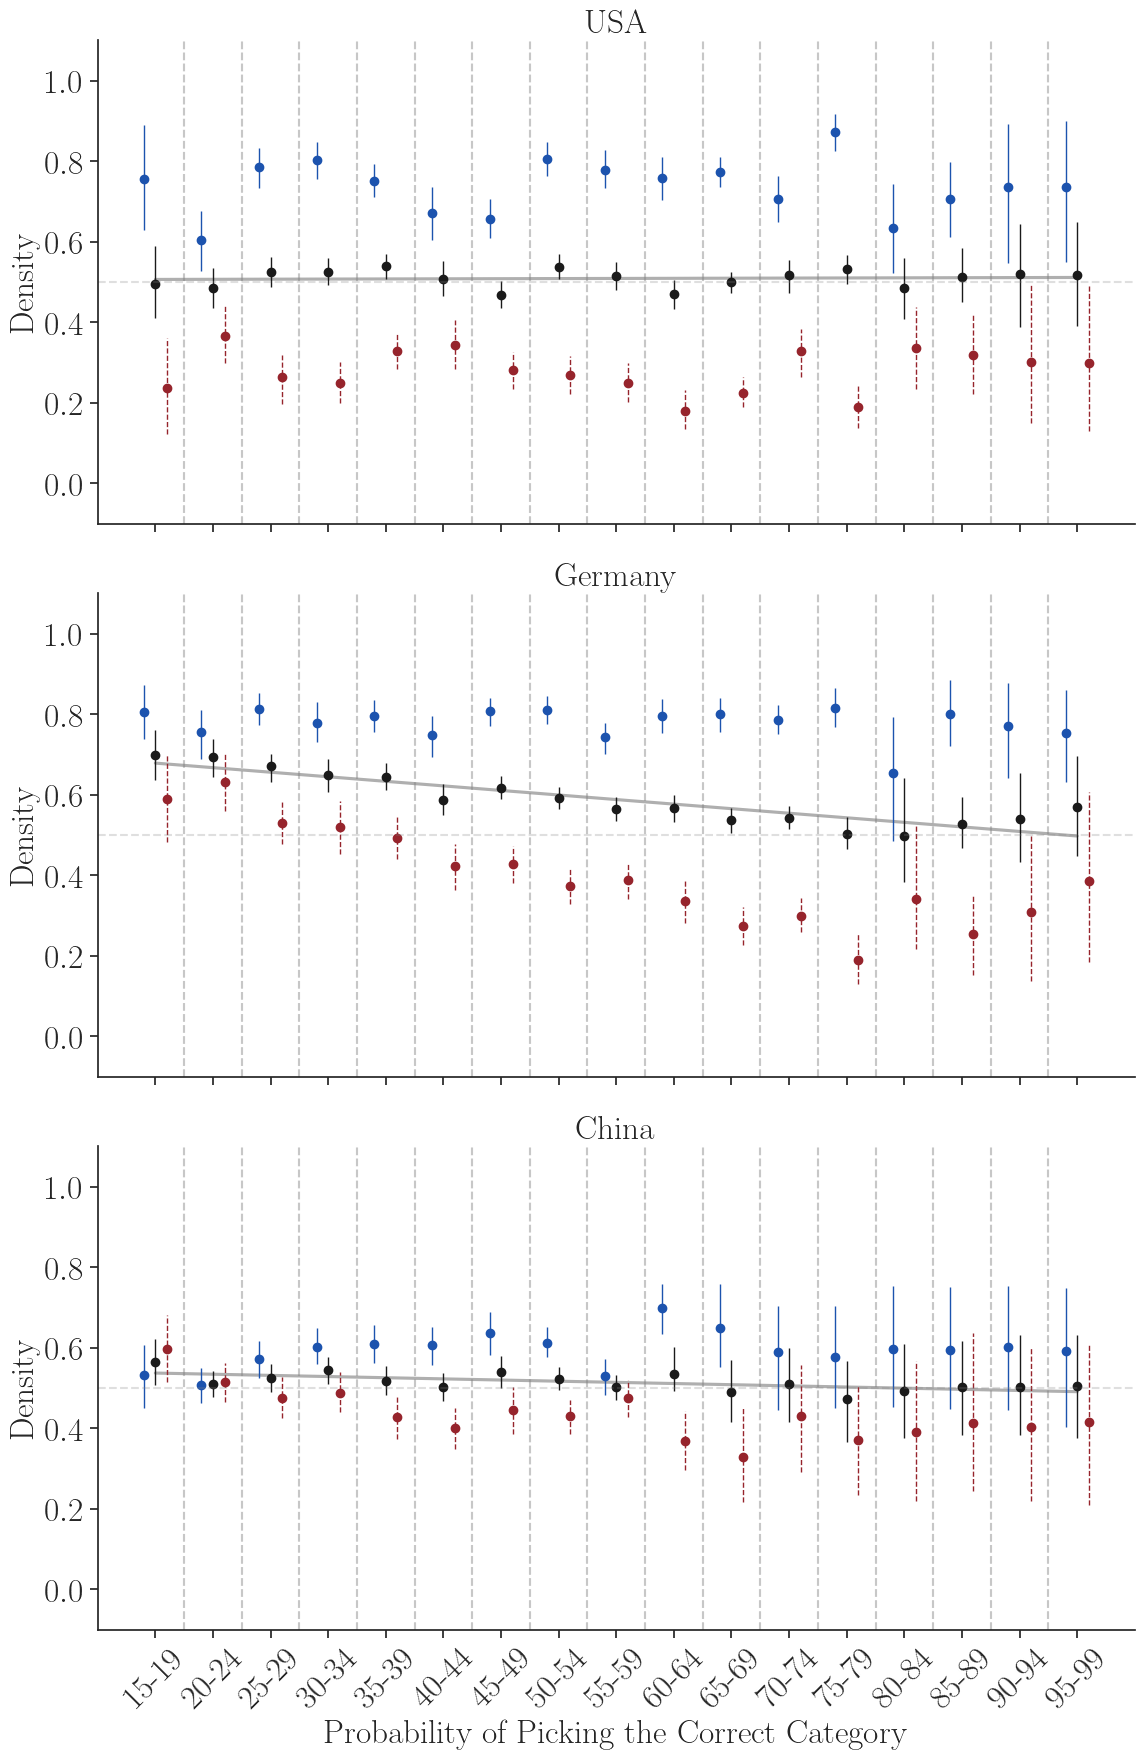

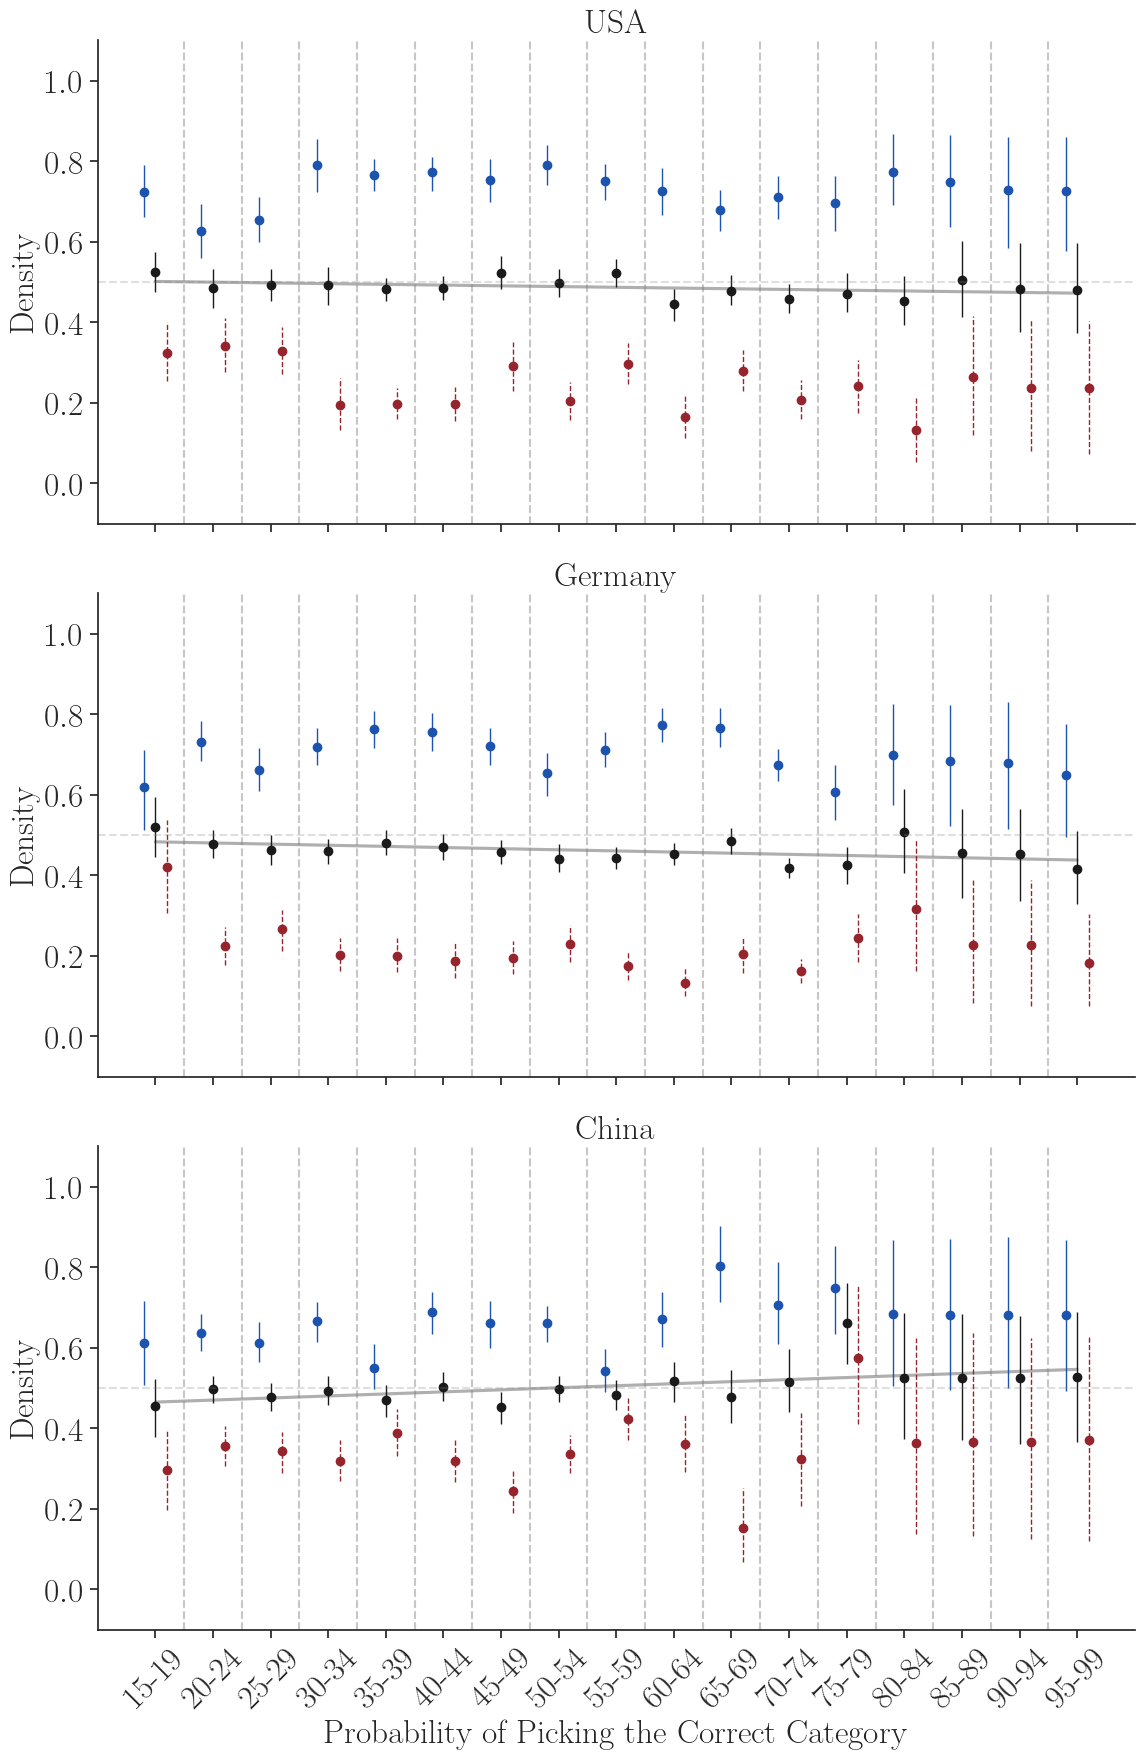

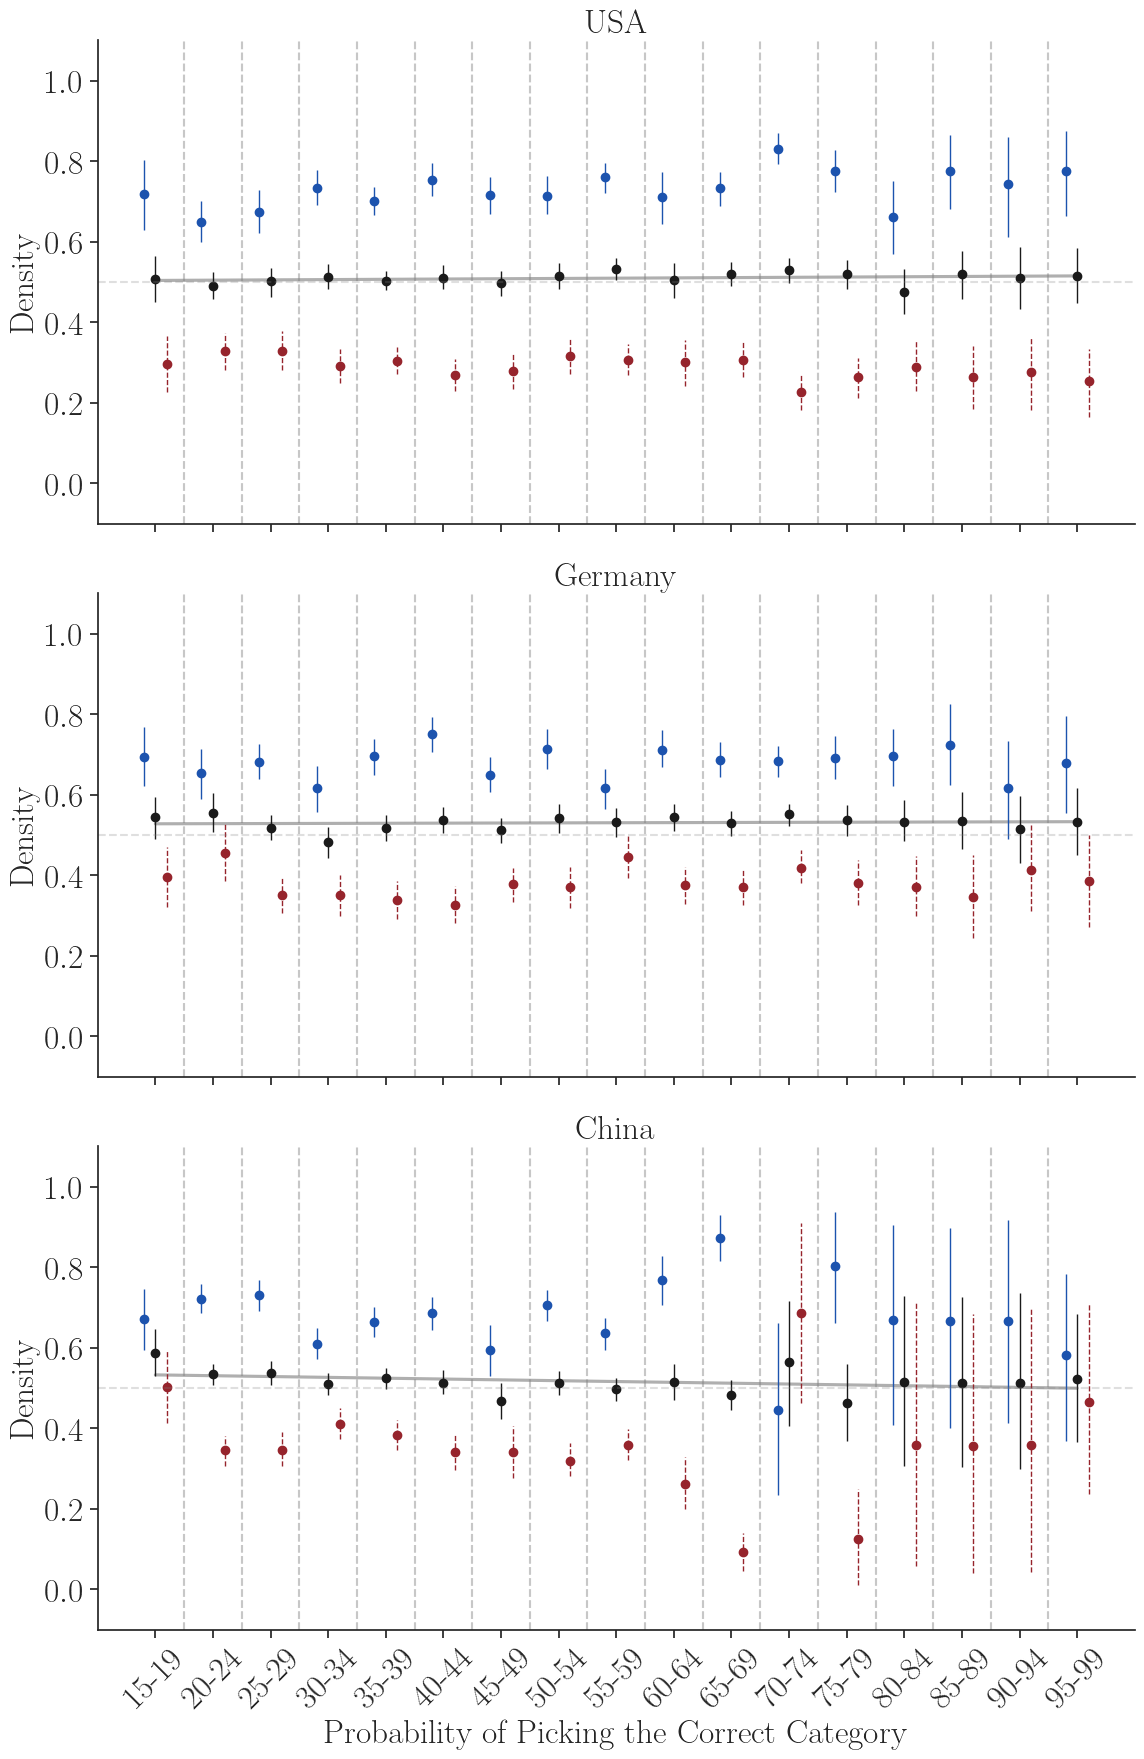

In [7]:
from scipy.stats import pearsonr

def plot_age_predictor(data, title, figsize=(12,3*6), plot_mean: bool = True):
    fig, axes = plt.subplots(figsize=figsize, facecolor="white", sharex=True, sharey=True, nrows=3)
    n_age_bins = len(data.posterior.coords["Age"])

    colors = plotting.DIVERGING_COLORS[-1]

    country_offset = [-.2, .2]

    for cidx, country in enumerate(["USA", "Germany", "China"]):
        ax = axes[cidx]

        sel_args = {
            "Country": country,
        }
        alpha = data.posterior.alpha.sel(sel_args)
        preds = [alpha]

        # include other predictors mean
        if "edu" in data.posterior.data_vars:
            edu = data.posterior.edu.sel(sel_args).mean(dim="Education")
        
            preds.append(edu)

        # include other predictors mean
        if "time" in data.posterior.data_vars:
            time = data.posterior.time.sel(sel_args)

            idx = data.constant_data.country_idx == cidx
            median_median_country = data.constant_data.median_time[idx].median()
            preds.append(median_median_country * time)

        # calculate age specific offset
        posterior = []

        for i in range(n_age_bins):
            log_odds = data.posterior.age.sel(sel_args)[:, :, :, i] + np.sum(preds, axis=0)
            posterior.append(logistic(log_odds))

        if plot_mean:
            # compute the mean diff between real and fake
            points = []
            means = []
            for i in range(n_age_bins):
                post_data = posterior[i].mean(dim="Type")
                mean = post_data.mean().values
                low, high = az.hdi(post_data).age.values

                point = i + 1
                points.append(point)
                means.append(mean)


                ax.plot(point, mean,  "o", color="k", label="Marginal")
                ax.vlines(point, low, high, color="k", linewidth=1)

            sn.regplot(x=points, y=means, ax=ax, color="k", scatter=False, ci=0, line_kws={"alpha":.35})


        for midx, media_type in enumerate(["Real", "Fake"]):
            if midx == 0:
                plot_kwargs = {
                    "label":f"Human {country}",
                }
            else:
                plot_kwargs = {
                    "label":f"Machine {country}",
                    "linestyle": "--",
                }

            color = colors[midx]

            labels = {}
            points = []

            for i in range(n_age_bins):
                post_data  = posterior[i].sel({"Type": media_type})
                mean = post_data.mean().values
                low, high = az.hdi(post_data).age.values

                point = i + 1
                labels[point] = utils.AGE_LABELS[i]

                offset_point = point + country_offset[midx]
                ax.plot(offset_point, mean,  "o", color=color, **plot_kwargs)
                ax.vlines(offset_point, low, high, color=color, linewidth=1, **plot_kwargs)

                points.append(offset_point)

                if i < n_age_bins - 1:
                    ax.axvline(point + .5, color="grey", linestyle="--", alpha=.25)

            # technically we set this twitce, but its the same anyway
            ticks, labels = list(zip(*labels.items()))
            ax.set_xticks(ticks)
            ax.set_xticklabels(labels, rotation = 45)


        ax.set_ylim((-0.1, 1.1))
        ax.set_xlim((0, n_age_bins + 1))
        # ax.set_ylabel(media_type, fontsize=14)
        ax.set_title(country, fontsize="large")
        ax.tick_params(labelsize="large")
        ax.axhline(.5, color="grey", linestyle="--", alpha=.25)



        ax.set_ylabel("Density", fontsize="large")

        if cidx == 2:
            ax.set_xlabel("Probability of Picking the Correct Category", fontsize="large")


    fig.tight_layout()
    fig.savefig(f"plot/{title.lower()}_age_posterior.pdf")

plot_age_predictor(time_age_edu_audio_trace, "Audio")
plot_age_predictor(time_age_edu_image_trace, "Image")
plot_age_predictor(time_age_text_trace, "Text")

Audio
USA -1.000 0.000 significant
Audio
Germany 0.500 0.667 non significant
Audio
China -1.000 0.000 significant
Image
USA -0.500 0.667 non significant
Image
Germany 0.500 0.667 non significant
Image
China 0.500 0.667 non significant


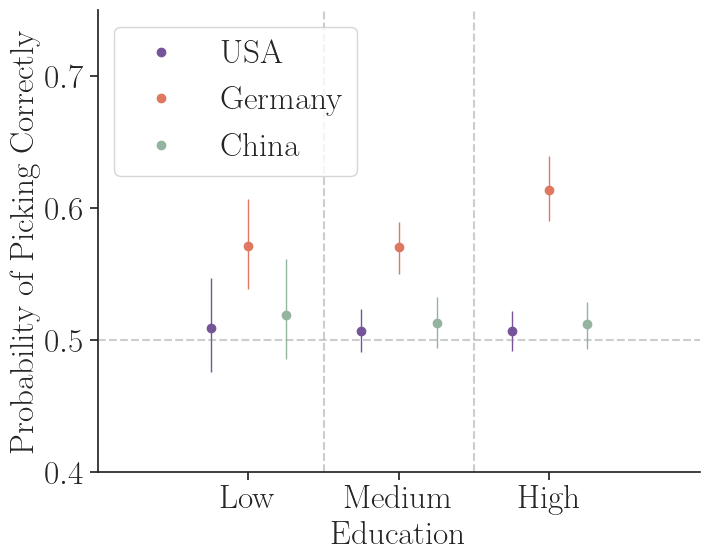

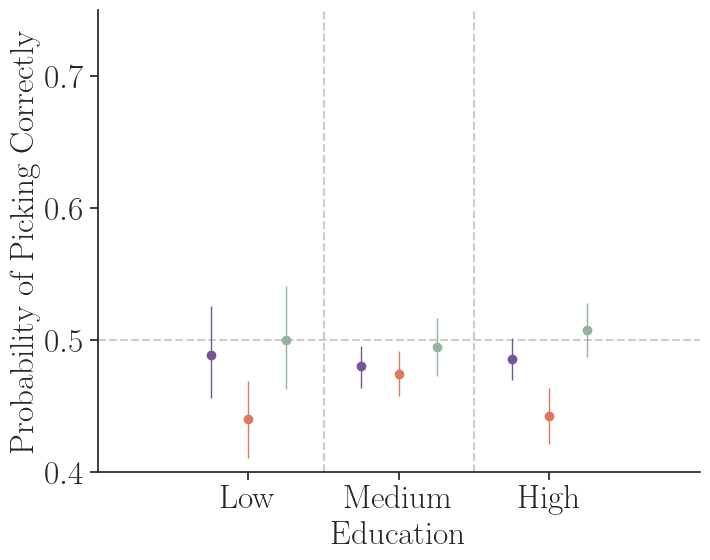

In [57]:

def plot_edu_predictor(data, title, figsize=(7.5, 6), legend: bool = False):
    fig, ax = plt.subplots(figsize=figsize, facecolor="white")
    n_edu_bins = len(data.posterior.coords["Education"])

    colors = plotting.COLORS[-1]

    country_offset = [-.25, 0., .25]

    for cidx, country in enumerate(["USA", "Germany", "China"]):
        sel_args = {
            "Country": country,
        }
        alpha = data.posterior.alpha_c.sel(sel_args)
        preds = [alpha]

        # include other predictors mean
        if "age" in data.posterior.data_vars:
            age = data.posterior.age.sel(sel_args).mean(dim="Age")

            preds.append(age)

        # include other predictors mean
        if "time" in data.posterior.data_vars:
            time = data.posterior.time.sel(sel_args)

            idx = data.constant_data.country_idx == cidx
            median_median_country = data.constant_data.median_time[idx].median(
            )
            preds.append(median_median_country * time)

        # calculate age specific offset
        posterior = []

        for i in range(n_edu_bins):
            log_odds = data.posterior.edu.sel(
                sel_args)[:, :, i] + np.sum(preds, axis=0)
            posterior.append(logistic(log_odds))

        labels = {}
        points = []
        means = []
        color = colors[cidx]

        for i in range(n_edu_bins):
            post_data = posterior[i]
            mean = post_data.mean().values
            low, high = az.hdi(post_data).edu.values

            point = i + 1
            labels[point] = utils.EDU_LABELS[i]

            offset_point = point + country_offset[cidx]

            if i == 0:
                ax.plot(offset_point, mean,  "o",
                        color=color, label=country)
            else:
                ax.plot(offset_point, mean,  "o", color=color)


            ax.vlines(offset_point, low, high, color=color,
                      linewidth=1)

            points.append(offset_point)
            means.append(mean)

            if i < n_edu_bins - 1:
                ax.axvline(point + .5, color="grey", linestyle="--", alpha=.15)

        corr, pval = spearmanr(points, means)
        print(title)
        print(
            f"{country} {corr:.3f} {pval:.3f} {'significant' if pval < 0.01 else 'non significant'}")

        # ax.set_title(title)
        ax.axhline(.5, color="grey", linestyle="--", alpha=.15)
        ax.set_ylim((0.4, 0.75))
        ax.set_xlim((0, n_edu_bins + 1))
        # ax.set_ylabel(media_type, fontsize=14)
        ax.tick_params(labelsize="large")

        ticks, labels = list(zip(*labels.items()))
        ax.set_xticks(ticks)
        ax.set_xticklabels(labels) #, rotation=45)

        ax.set_ylabel("Probability of Picking Correctly", fontsize="large")

        if cidx == 2:
            ax.set_xlabel("Education", fontsize="large")

        if legend:
            ax.legend(fontsize="large", loc="upper left")

    # fig.suptitle(title, fontsize="large")

    fig.tight_layout()
    fig.savefig(f"plot/{title.lower()}_edu_posterior.pdf")


audio_trace = az.from_netcdf(
    "traces/accuracy/interval/demographics/audio/time_age_edu.nc").load()
plot_edu_predictor(audio_trace, "Audio", legend=True)

image_trace = az.from_netcdf(
    "traces/accuracy/interval/demographics/image/time_age_edu.nc").load()
plot_edu_predictor(image_trace, "Image")

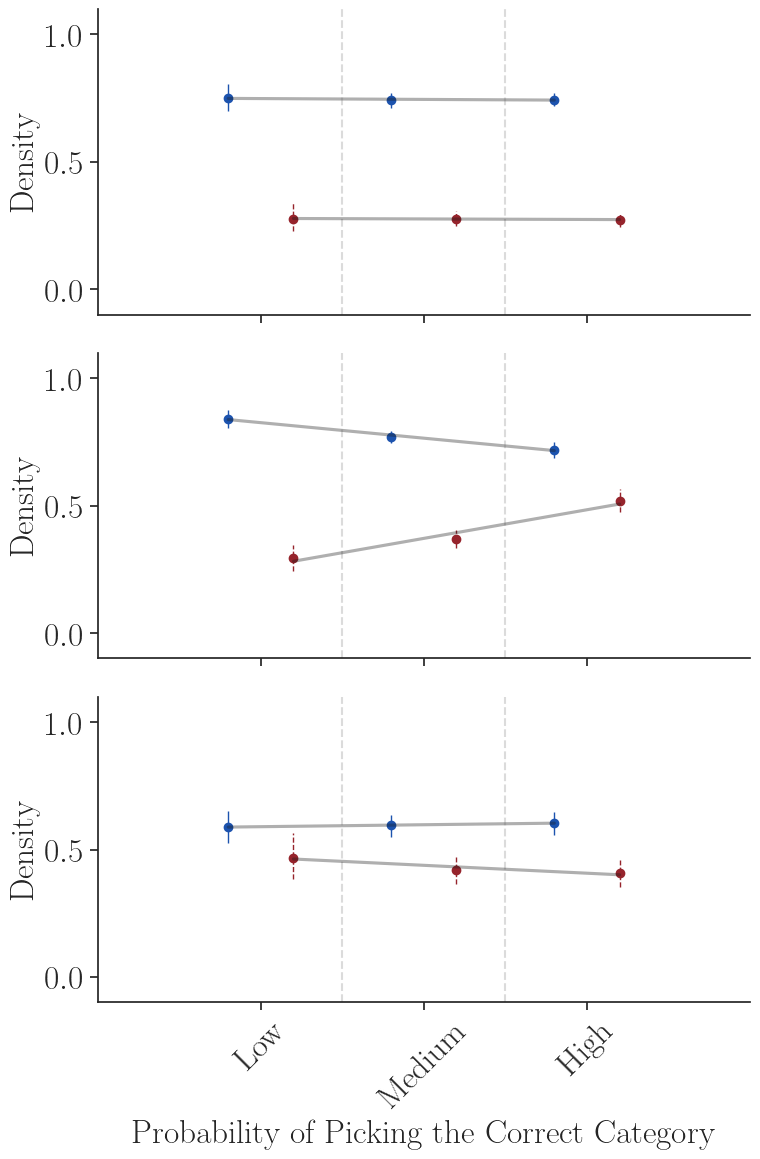

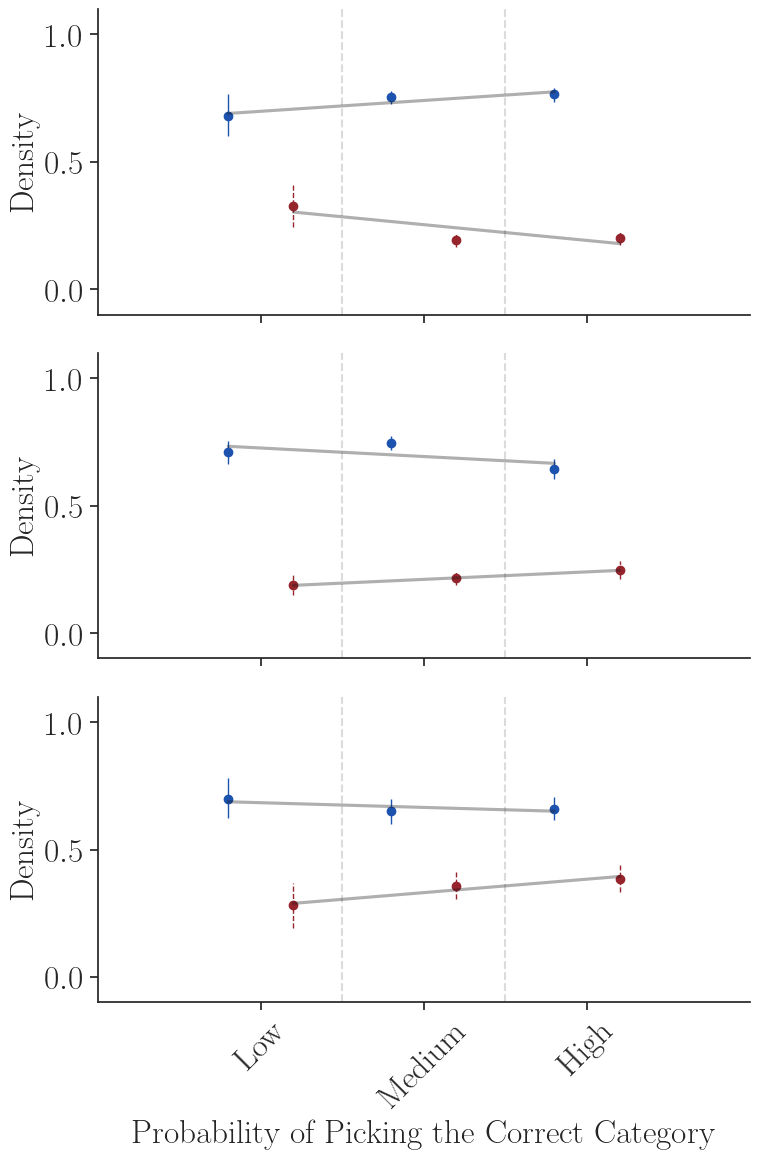

In [24]:

def plot_edu_predictor(data, title, figsize=(8,12)):
    fig, axes = plt.subplots(figsize=figsize, facecolor="white", sharex=True, sharey=True, nrows=3)
    n_edu_bins = len(data.posterior.coords["Education"])

    colors = plotting.DIVERGING_COLORS[-1]

    country_offset = [-.2, .2]

    for cidx, country in enumerate(["USA", "Germany", "China"]):
        ax = axes[cidx]
        for midx, media_type in enumerate(["Real", "Fake"]):

            sel_args = {
                "Country": country,
                "Type": media_type,
            }
            alpha = data.posterior.alpha.sel(sel_args)
            preds = [alpha]

            # include other predictors mean
            if "age" in data.posterior.data_vars:
                age = data.posterior.age.sel(sel_args).mean(dim="Age")

                preds.append(age)


            # include other predictors mean
            if "time" in data.posterior.data_vars:
                time = data.posterior.time.sel(sel_args)

                idx = data.constant_data.country_idx == cidx
                median_median_country = data.constant_data.median_time[idx].median()
                preds.append(median_median_country * time)

            # calculate age specific offset
            posterior = []

            for i in range(n_edu_bins):
                log_odds = data.posterior.edu.sel(sel_args)[:, :, i] + np.sum(preds, axis=0)
                posterior.append(logistic(log_odds))


            if midx == 0:
                plot_kwargs = {
                    "label":f"Human {country}",
                }
            else:
                plot_kwargs = {
                    "label":f"Machine {country}",
                    "linestyle": "--",
                }

            labels = {}
            points = []
            means = []
            color = colors[midx]

            for i in range(n_edu_bins):
                post_data  = posterior[i]
                mean = post_data.mean().values
                low, high = az.hdi(post_data).edu.values

                point = i + 1
                labels[point] = utils.EDU_LABELS[i]

                offset_point = point + country_offset[midx]
                ax.plot(offset_point, mean,  "o", color=color, **plot_kwargs)
                ax.vlines(offset_point, low, high, color=color, linewidth=1, **plot_kwargs)

                points.append(offset_point)
                means.append(mean)

                if i < n_edu_bins - 1:
                    ax.axvline(point + .5, color="grey", linestyle="--", alpha=.15)


            # ax.plot(points, means, color=color, linewidth=1, **plot_kwargs)

            ax.set_ylim((-0.1, 1.1))
            ax.set_xlim((0, n_edu_bins + 1))
            # ax.set_ylabel(media_type, fontsize=14)
            ax.tick_params(labelsize="large")


            ticks, labels = list(zip(*labels.items()))
            ax.set_xticks(ticks)
            ax.set_xticklabels(labels, rotation = 45)

            ax.set_ylabel("Density", fontsize="large")

            if cidx == 2:
                ax.set_xlabel("Probability of Picking the Correct Category", fontsize="large")


    # fig.suptitle(title, fontsize="large")

    fig.tight_layout()
    fig.savefig(f"plot/{title.lower()}_edu_posterior.pdf")

plot_edu_predictor(time_age_edu_audio_trace, "Audio")
plot_edu_predictor(time_age_edu_image_trace, "Image")

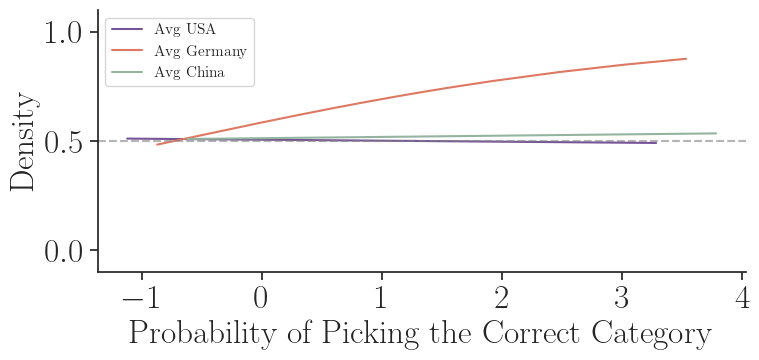

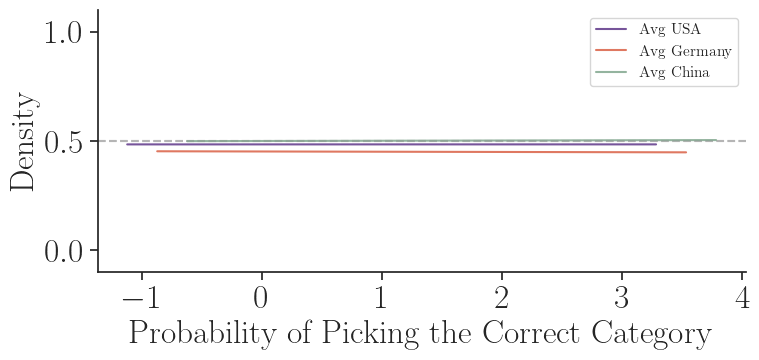

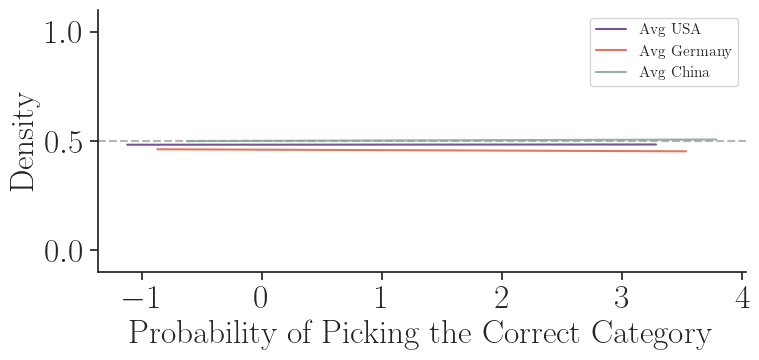

In [46]:
def plot_time_predictor(data, title, figsize=(8, 4)):
    fig, ax = plt.subplots(figsize=figsize, facecolor="white")

    colors = plotting.COLORS[-1]
    offsets = [-.25, 0., .25]

    for cidx, country in enumerate(["USA", "Germany", "China"]):
        sel_args = {
            "Country": country,
        }
        alpha = data.posterior.alpha_c.sel(sel_args)
        preds = [alpha]

        # include other predictors mean
        if "age" in data.posterior.data_vars:
            age = data.posterior.age.sel(sel_args).mean(dim="Age")

            preds.append(age)

            # include other predictors mean
        if "edu" in data.posterior.data_vars:
            edu = data.posterior.edu.sel(sel_args).mean(dim="Education")

            preds.append(edu)

        # include other predictors mean
        if "time" in data.posterior.data_vars:
            time = data.posterior.time.sel(sel_args)

            idx = data.constant_data.country_idx == cidx
            median_median_country = data.constant_data.median_time[idx].median(
            )
            preds.append(median_median_country * time)

        # calculate age specific offset
        idx = time_age_edu_audio_trace.constant_data.country_idx == 0
        times = time_age_edu_audio_trace.constant_data.median_time[idx]

        log_odds = times * \
            data.posterior.time.sel(sel_args) + np.sum(preds, axis=0)
        posterior = logistic(log_odds)

        means = posterior.mean(dim=("chain", "draw")).values

        times += offsets[cidx]
        sn.lineplot(x="Time used", y="Density", data=pd.DataFrame({"Time used": times, "Density": means}), color=colors[cidx], label=f"Avg {country}")

        ax.set_ylim((-0.1, 1.1))
        ax.tick_params(labelsize="large")
        ax.axhline(.5, color="grey", linestyle="--", alpha=.25)

        ax.set_ylabel("Density", fontsize="large")

        if cidx == 2:
            ax.set_xlabel(
                "Probability of Picking the Correct Category", fontsize="large")


    # fig.suptitle(title, fontsize="large")

    fig.tight_layout()
    fig.savefig(f"plot/{title.lower()}_edu_posterior.pdf")

audio_trace=az.from_netcdf(
    "traces/accuracy/interval/demographics/audio/time_age_edu.nc").load()
plot_time_predictor(audio_trace, "Audio")
image_trace=az.from_netcdf(
    "traces/accuracy/interval/demographics/image/time_age_edu.nc").load()
plot_time_predictor(image_trace, "Image")
text_trace=az.from_netcdf(
    "traces/accuracy/interval/demographics/image/time_age.nc").load()
plot_time_predictor(text_trace, "Text")


In [12]:
from collections import deque
from math import comb

from matplotlib.gridspec import GridSpec


def _compute_combinations(post_data):
    dims = list(filter(lambda x: x not in["chain", "draw"], post_data.dims))
    combinations = deque([()])
    for dim in dims:
        for _ in range(len(combinations)):
            cur = combinations.popleft()
            for d in post_data.coords[dim]:
                combinations.append((*cur, (dim, str(d.values))))

    return combinations

def extract_trace_data(traces, hdi_prob=.89):
    extracted = []
    for trace in traces:
        predictors = [var for var in trace.posterior.data_vars if "beta_" in var]

        for pred in predictors:
            if "device" in pred:
                continue 

            post_data = trace.posterior[pred]
            combinations = _compute_combinations(post_data)

            for comb in combinations:
                sel = dict(comb)
                sel_data = post_data.sel(sel)

                mean = sel_data.mean().values
                low, high = az.hdi(sel_data, hdi_prob=hdi_prob)[pred].values
                if mean > 0:
                    percentage = (sel_data > 0.).sum() / sel_data.count()
                else:
                    percentage = (sel_data < 0.).sum() / sel_data.count()

                series = pd.Series(
                    [pred.replace("beta_", "").replace("_", " "), *list(sel.values()), mean, low, high, percentage.values],
                    index=["name", *list(sel.keys()), "mean", "low", "high", "percentage"],
                )
                extracted.append(series)

    return pd.concat(extracted, axis=1).transpose()


def plot_forest_single_category(path, title, jitter=.05, spacer=.25, legend=True, labels=True, prev_ax=None, fontsize=20):
    # extract predictors
    traces = [az.from_netcdf(path) for path in path.glob("*.nc")]
    predictors = extract_trace_data(traces)

    # n_predictors = predictors.name.nunique()
   
    fig, ax = plt.subplots(facecolor="white", figsize=(3 * 3, 10))
    if prev_ax is not None:
        ax.sharex(prev_ax)

    colors = plotting.DIVERGING_COLORS[-1]
    y = 0
    ticks_and_labels = {}

    for pred in sorted(predictors.name.unique()):
        # if "PO" in pred:
        #     continue

        for j, (jit, media_type) in enumerate([(jitter, "Real"), (-jitter, "Fake")]):
            d = predictors[(predictors.Type == media_type) & (predictors.name == pred)]

            point = y + jit

            if y == 0:
                label = "Human" if media_type == "Real" else "Machine"
                ax.scatter(d["mean"], point, color=colors[j], label=label)
            else:
                ax.scatter(d["mean"], point, color=colors[j])
            ax.hlines(point, d["low"], d["high"], color=colors[j])

        ticks_and_labels[y] = f"{pred}"
        y -= spacer

    # remove spines and ticks
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    
    if legend:
        ax.legend(loc="upper right", fontsize=fontsize+4)

    if labels:
        ticks, ticklabels = list(zip(*ticks_and_labels.items()))
        ax.set_yticks(ticks)
        ax.set_yticklabels(ticklabels)
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])

    ax.axvline(0, color="k", linestyle="--")
    ax.tick_params(which='major', labelsize=fontsize)

    fig.tight_layout()
    fig.savefig(f"plot/accuracy_variables_{title.lower()}.pdf")

    predictors["category"] = title

    return predictors, ax

audio_predictors, ax = plot_forest_single_category(path=Path("traces/real_fake/interval/fixed/audio/"), title="Audio", legend=False)
image_predictors, ax = plot_forest_single_category(path=Path("traces/real_fake/interval/fixed/image/"), title="Image", prev_ax=ax, legend=False)
text_predictors, ax = plot_forest_single_category(path=Path("traces/real_fake/interval/fixed/text/"), title="Text", prev_ax=ax)

[]


ValueError: No objects to concatenate

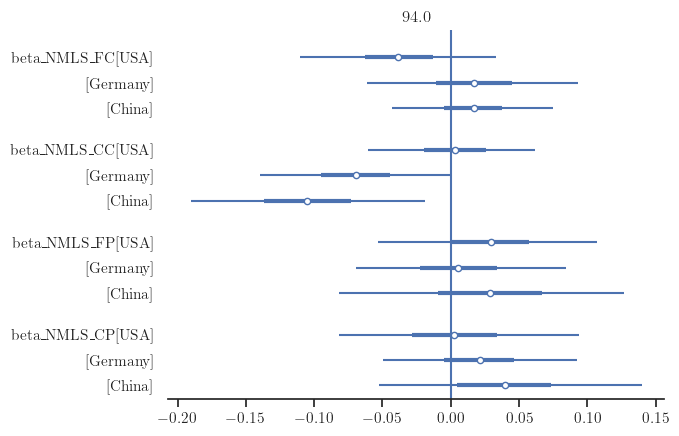

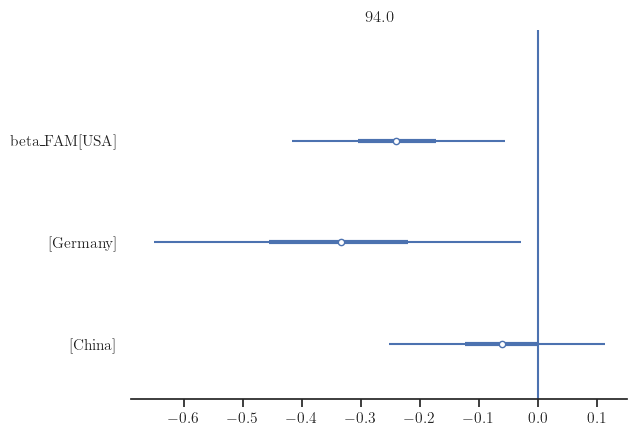

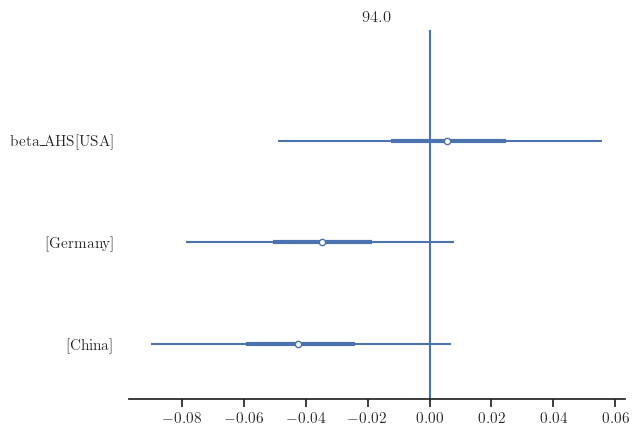

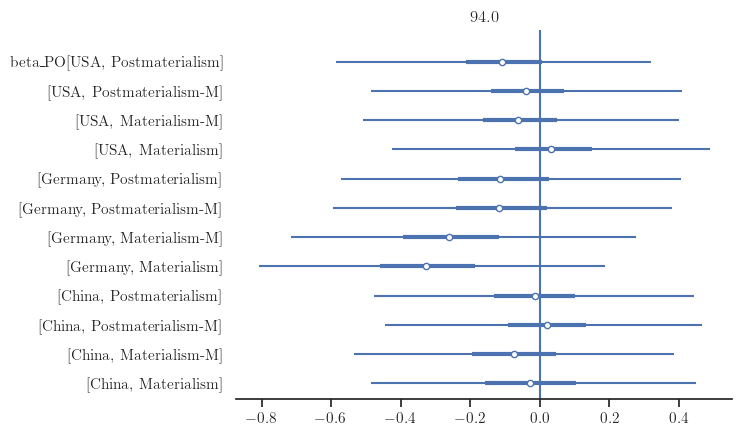

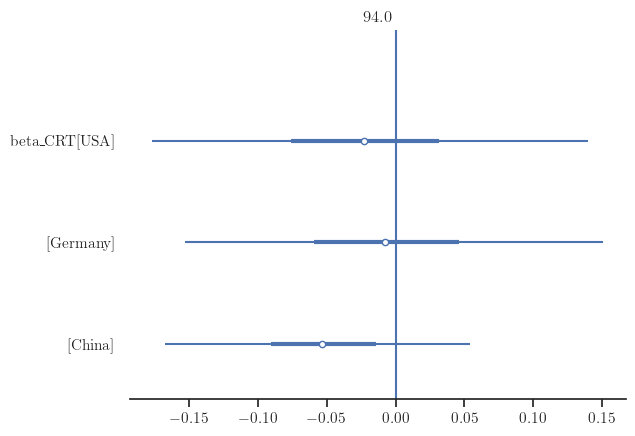

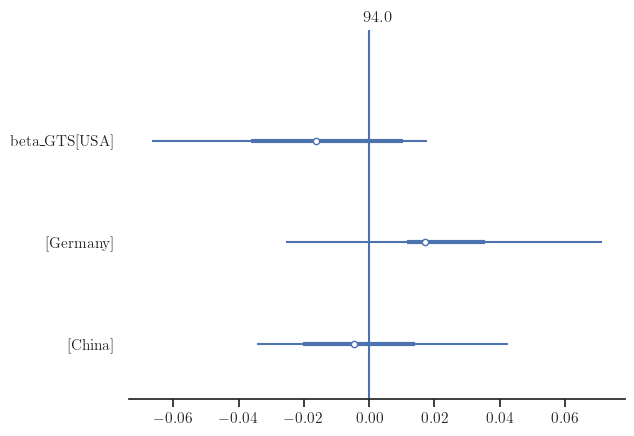

In [50]:

for path in Path("archive/submission/traces/accuracy/interval/fixed_country/image").glob("*.nc"):
    fig, ax = plt.subplots()
    az.plot_forest(az.from_netcdf(path), filter_vars="like", var_names="beta", ax=ax, combined=True)
    ax.axvline(0)


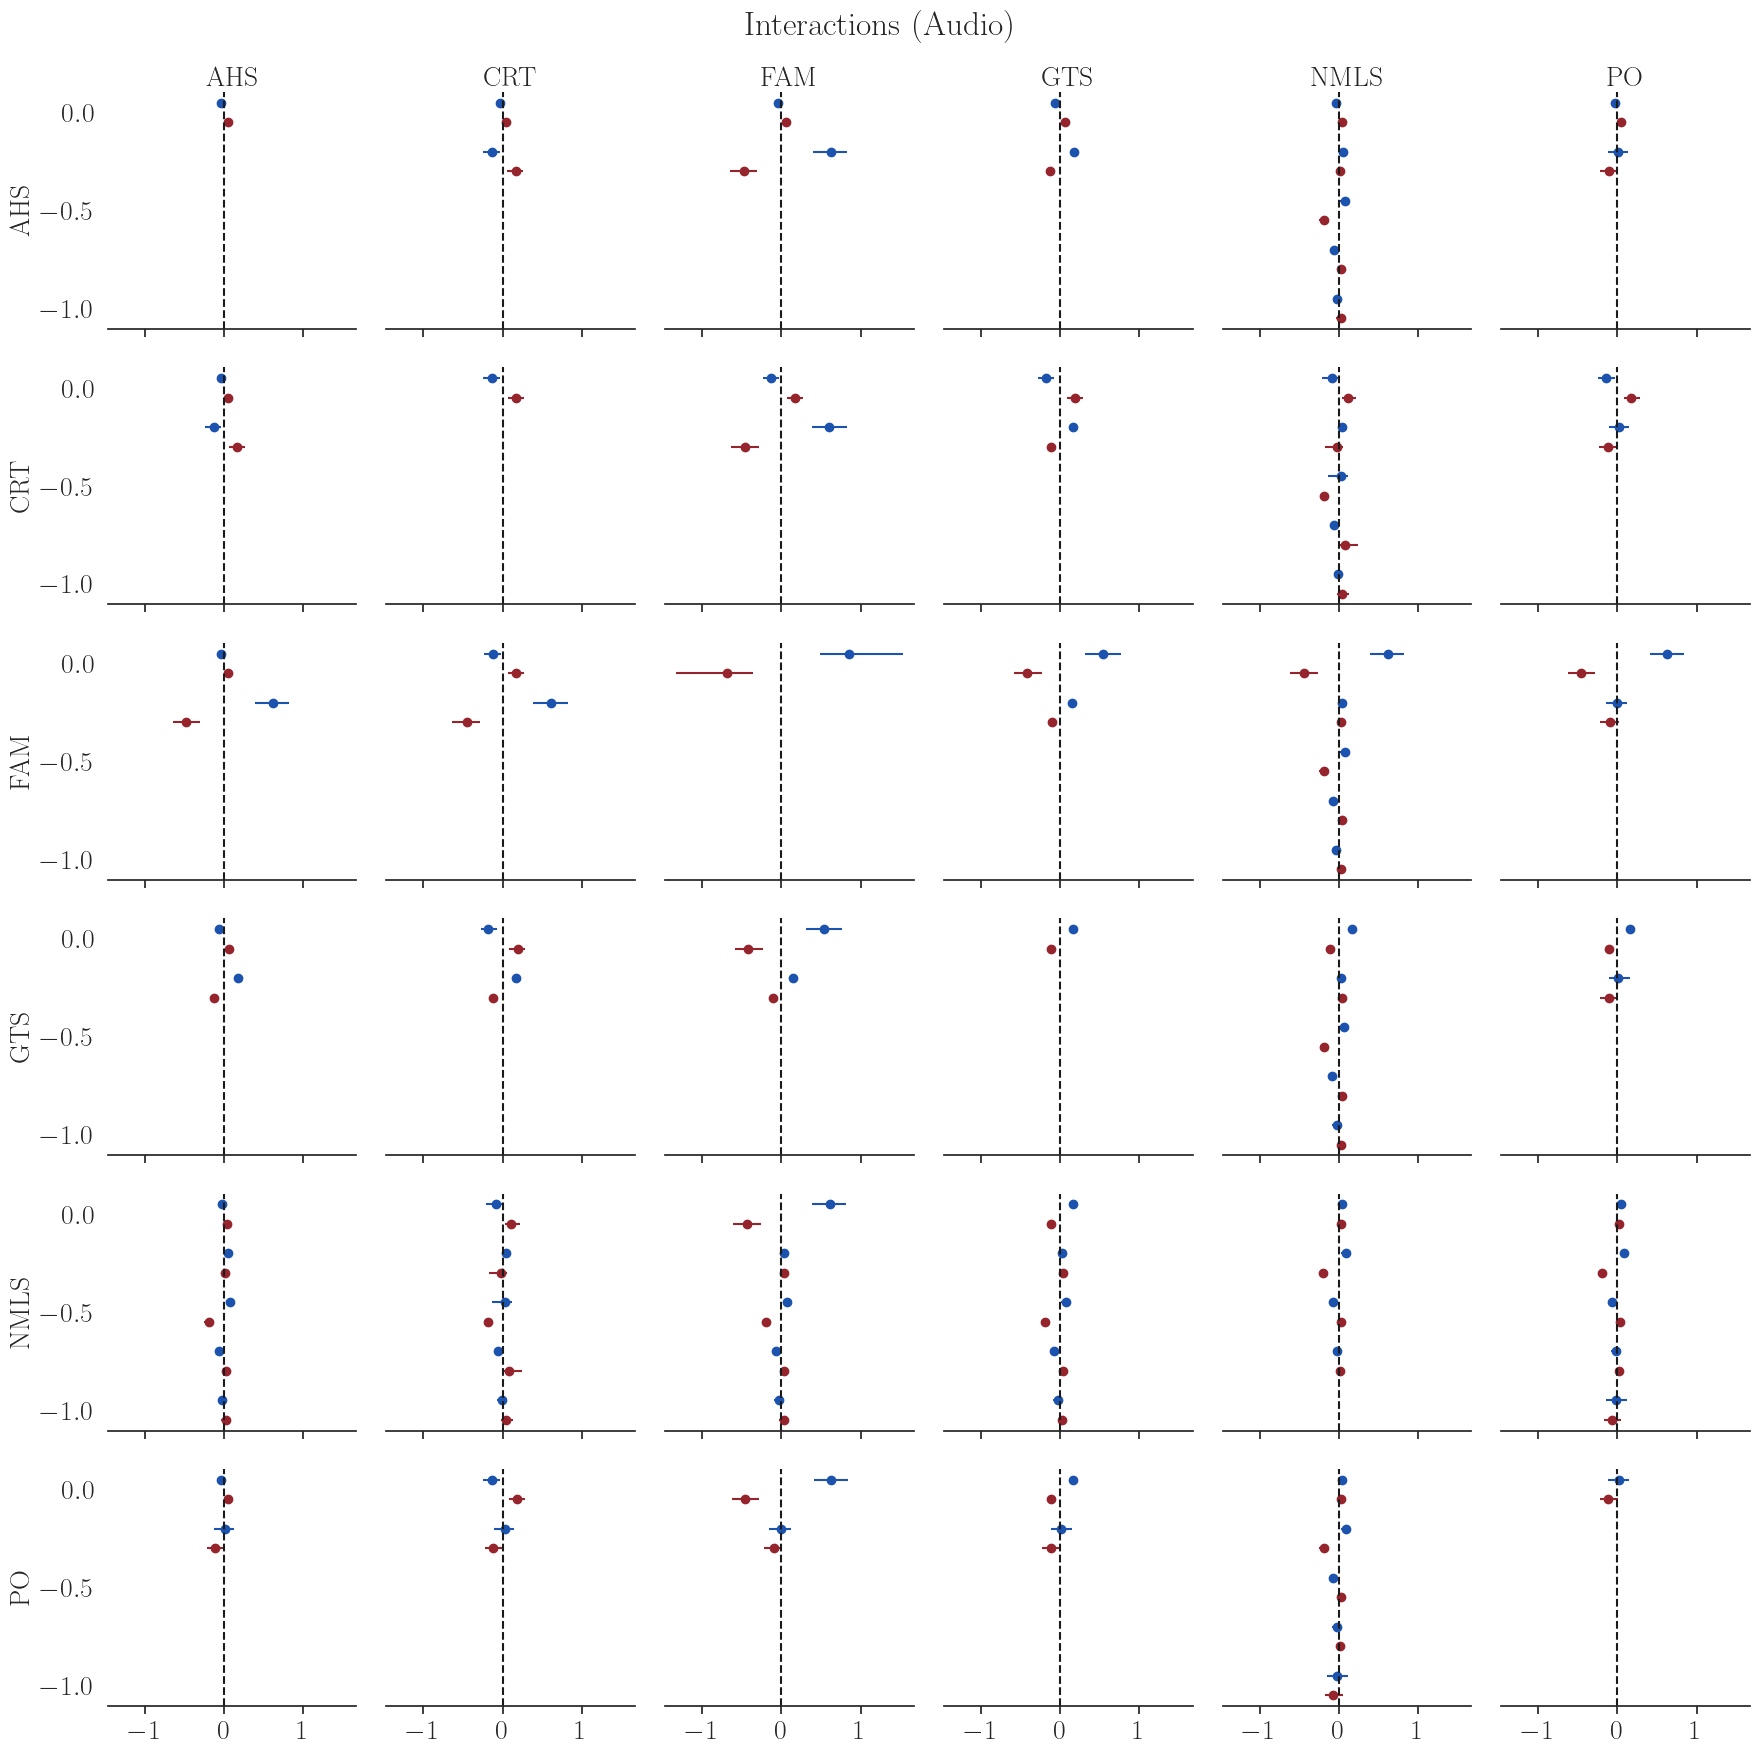

In [91]:
import re

PREDICTORS_RE = re.compile("(AHS|GTS|PO|CRT|FAM|NMLS)+")
PREDICTORS_ORDER = ["AHS", "CRT", "FAM", "GTS", "NMLS", "PO"]

def predictors_to_traces(path: Path):
    pred_to_trace = dict()
    for trace in path.glob("**/*.nc"):
        predictors = set(PREDICTORS_RE.findall(str(trace)))
        pred_to_trace[tuple(sorted(predictors))] = az.from_netcdf(trace)

    return pred_to_trace



def plot_forest_interaction_comparison(single_path: Path, multi_path: Path, title, jitter=.05, spacer=.25, legend=True, labels=True, prev_ax=None, fontsize=20):
    # map predictors to traces
    pred_to_trace = predictors_to_traces(single_path)
    pred_to_trace.update(predictors_to_traces(multi_path))
    n_predictors = len(PREDICTORS_ORDER)

    fig, axes = plt.subplots(nrows=n_predictors, ncols=n_predictors, facecolor="white", figsize=(3*n_predictors, 3*n_predictors), sharex=True, sharey=True)
    colors = plotting.DIVERGING_COLORS[-1]

    for i in range(n_predictors):
        for j in range(n_predictors):
            key = tuple(sorted(set((PREDICTORS_ORDER[i], PREDICTORS_ORDER[j]))))
            ax = axes[i, j]

            # extract predictor data
            trace = pred_to_trace[key]
            predictors = extract_trace_data([trace])


            # plot predictors
            y = 0

            for pred in sorted(predictors.name.unique()):
                ticks_and_labels = {}

                for k, (jit, media_type) in enumerate([(jitter, "Real"), (-jitter, "Fake")]):
                    d = predictors[(predictors.Type == media_type) & (predictors.name == pred)]

                    point = y + jit

                    if y == 0:
                        label = "Human" if media_type == "Real" else "Machine"
                        ax.scatter(d["mean"], point, color=colors[k], label=label)
                    else:
                        ax.scatter(d["mean"], point, color=colors[k])
                    ax.hlines(point, d["low"], d["high"], color=colors[k])

                ticks_and_labels[y] = f"{pred}"
                y -= spacer


            # formatting
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.yaxis.set_ticks_position('none')

            if j == 0:
                ax.set_ylabel(PREDICTORS_ORDER[i], fontsize=fontsize)

            if i == 0:
                ax.set_xlabel(PREDICTORS_ORDER[j], fontsize=fontsize)
                ax.xaxis.set_label_position('top') 
            
            # if i != j:
            #     ticks, ticklabels = list(zip(*ticks_and_labels.items()))
            #     ax.set_yticks(ticks)
            #     ax.set_yticklabels(ticklabels)
            # else:
            #     ax.set_yticks([])
            #     ax.set_yticklabels([])

            ax.axvline(0, color="k", linestyle="--")
            ax.tick_params(which='major', labelsize=fontsize)

    fig.suptitle(title)
    fig.tight_layout()
    fig.savefig(f"plot/accuracy_variables_{title.lower()}.pdf")

    # predictors["category"] = title

plot_forest_interaction_comparison(
    single_path=Path("traces/real_fake/interval/fixed/audio/"),
    multi_path=Path("traces/real_fake/combinations/fixed/audio/"),
    title="Interactions (Audio)",
)


/Users/joelfrank/.pyenv/versions/3.10.7/envs/datascience/lib/python3.10/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/joelfrank/.pyenv/versions/3.10.7/envs/datascience/lib/python3.10/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.wa

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
NMLS_GTS,0,-6162.78,405.34,0.00,0.44,149.05,0.00,True,log
NMLS_FAM,1,-6177.47,413.37,14.69,0.25,151.89,26.51,True,log
NMLS,2,-6191.71,402.15,28.93,0.00,151.54,21.97,True,log
NMLS_AHS,3,-6193.27,404.78,30.49,0.00,151.28,22.88,True,log
base,4,-6196.64,367.98,33.86,0.31,152.34,29.32,True,log
NMLS_PO,5,-6199.10,414.84,36.32,0.00,152.04,21.92,True,log
NMLS_CRT,6,-6505.22,804.22,342.45,0.00,154.04,32.57,True,log


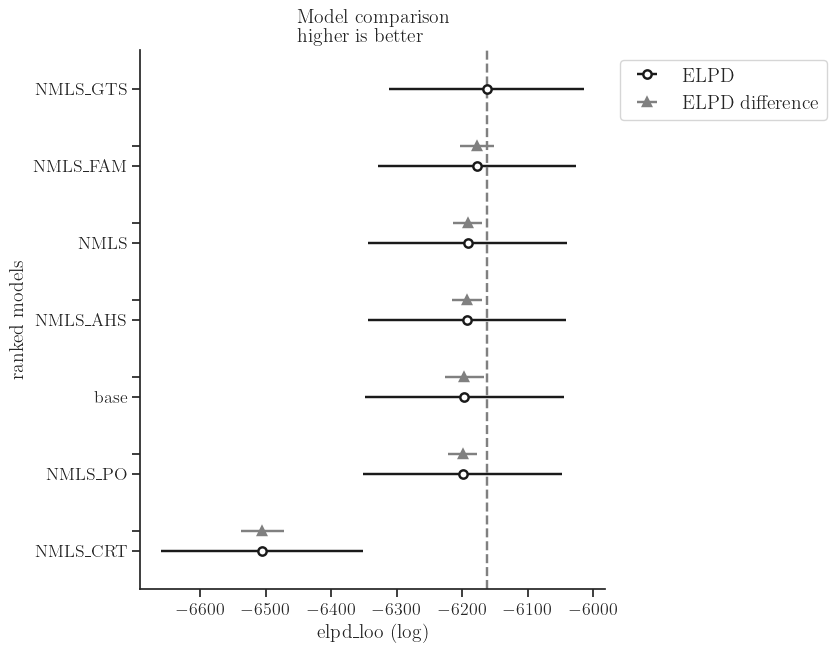

In [61]:

models = {
    "base": az.from_netcdf("traces/real_fake/interval/demographics/audio/age_edu.nc"),
    "NMLS": az.from_netcdf("traces/real_fake/interval/fixed/audio/age_edu_NMLS_FC_NMLS_CC_NMLS_FP_NMLS_CP.nc"),
    "NMLS_AHS": az.from_netcdf("traces/real_fake/combinations/fixed/audio/age_edu_AHS_NMLS_FC_NMLS_CC_NMLS_FP_NMLS_CP.nc"),
    "NMLS_GTS": az.from_netcdf("traces/real_fake/combinations/fixed/audio/age_edu_GTS_NMLS_FC_NMLS_CC_NMLS_FP_NMLS_CP.nc"),
    "NMLS_CRT": az.from_netcdf("traces/real_fake/combinations/fixed/audio/age_edu_NMLS_FC_NMLS_CC_NMLS_FP_NMLS_CP_CRT.nc"),
    "NMLS_FAM": az.from_netcdf("traces/real_fake/combinations/fixed/audio/age_edu_NMLS_FC_NMLS_CC_NMLS_FP_NMLS_CP_FAM.nc"),
    "NMLS_PO": az.from_netcdf("traces/real_fake/combinations/fixed/audio/age_edu_NMLS_FC_NMLS_CC_NMLS_FP_NMLS_CP_PO.nc"),
}

for key in models:
    models[key].log_likelihood["y"] = models[key].log_likelihood["y_real"] + models[key].log_likelihood["y_fake"]

comp = az.compare(
    models,
    var_name="y",
)

az.plot_compare(comp)
comp.round(2)

In [90]:
audio_predictors.sort_values(["name", "Type"])

,name,Type,mean,low,high,percentage,category
12,AHS,Fake,0.049761443837884584,0.016465,0.087795,0.9815,Audio
13,AHS,Real,-0.036308200831871563,-0.073298,-0.000295,0.944125,Audio
14,CRT,Fake,0.17144007154606133,0.070603,0.268653,0.998375,Audio
15,CRT,Real,-0.1378823276125758,-0.242206,-0.03515,0.9805,Audio
10,FAM,Fake,-0.6835897142450101,-1.323938,-0.356048,1.0,Audio
11,FAM,Real,0.8500994758536797,0.482189,1.531113,1.0,Audio
16,GTS,Fake,-0.11188065905605143,-0.147425,-0.0741,1.0,Audio
17,GTS,Real,0.16377543290942015,0.123677,0.20014,1.0,Audio
2,NMLS CC,Fake,0.024467344856432236,-0.019782,0.069245,0.808125,Audio
3,NMLS CC,Real,0.04534841619456651,-0.001206,0.090118,0.942625,Audio


In [91]:
image_predictors.sort_values(["name", "Type"])

,name,Type,mean,low,high,percentage,category
12,AHS,Fake,0.0007430710856906566,-0.039141,0.041112,0.514625,Image
13,AHS,Real,-0.04911229493308598,-0.08649,-0.01288,0.980625,Image
14,CRT,Fake,0.17389929167936988,0.078568,0.283528,0.996625,Image
15,CRT,Real,-0.21983132283070142,-0.314642,-0.114295,1.0,Image
10,FAM,Fake,0.21629768365442886,0.111523,0.323668,0.99825,Image
11,FAM,Real,-0.36051986197140024,-0.470578,-0.266049,1.0,Image
16,GTS,Fake,-0.10716983490083862,-0.14438,-0.069885,1.0,Image
17,GTS,Real,0.10570880490121948,0.068353,0.141263,1.0,Image
2,NMLS CC,Fake,0.0430730024541957,-0.014261,0.097406,0.8915,Image
3,NMLS CC,Real,-0.14461417204954127,-0.198581,-0.089675,1.0,Image


In [92]:
text_predictors.sort_values(["name", "Type"])

,name,Type,mean,low,high,percentage,category
6,AHS,Fake,-0.04291893803495666,-0.075885,-0.009235,0.978125,Text
7,AHS,Real,0.03825010419941588,0.004619,0.071823,0.96625,Text
2,CRT,Fake,0.15523322195717051,0.072441,0.248811,0.9955,Text
3,CRT,Real,-0.09327113114054164,-0.186208,-0.00831,0.950875,Text
8,FAM,Fake,0.18383403533812834,0.10194,0.263013,0.999875,Text
9,FAM,Real,-0.29902297943382367,-0.383164,-0.217216,1.0,Text
0,GTS,Fake,-0.10051938900054296,-0.132375,-0.066884,1.0,Text
1,GTS,Real,0.0850667885052226,0.053942,0.1216,0.999875,Text
12,NMLS CC,Fake,-0.11467089325861166,-0.160256,-0.069432,1.0,Text
13,NMLS CC,Real,0.09873933219653315,0.054387,0.144374,0.999625,Text


In [89]:
merged = pd.concat((audio_predictors, image_predictors, text_predictors))
merged["percentage"] = merged["percentage"].astype(float)
merged["mean"] = merged["mean"].astype(float)
merged["Type"] = pd.Categorical(merged["Type"], ["Real", "Fake"])

def format_beta(row):
    # f"{row[0]:.2f} "
    low = f"{row['low']:.2f}"
    if "-" not in low:
        low = f"\\phantom{{-}}{low}"

    high = f"{row['high']:.2f}"
    if "-" not in high:
        high = f"\\phantom{{-}}{high}"

    res = f"{row['mean']:2.2f} [{low}, {high}]"

    if row["percentage"] > .95:
        res = f"\\textbf{{{res}}}"

    return res

merged["beta"] = merged[["mean", "low", "high", "percentage"]].apply(format_beta, axis=1)

pivot = merged.pivot(index=["name", "Type"], columns="category", values=["beta"]).unstack(1)
pivot.columns = pivot.columns.droplevel(0)
pivot.columns.names = len(pivot.columns.names) * [None]
pivot.index.names = len(pivot.index.names) * [None]

print(pivot.style.to_latex())
pivot

\begin{tabular}{lllllll}
 & \multicolumn{2}{r}{Audio} & \multicolumn{2}{r}{Image} & \multicolumn{2}{r}{Text} \\
 & Real & Fake & Real & Fake & Real & Fake \\
AHS & -0.04 [-0.07, -0.00] & \textbf{0.05 [\phantom{-}0.02, \phantom{-}0.09]} & \textbf{-0.05 [-0.09, -0.01]} & 0.00 [-0.04, \phantom{-}0.04] & \textbf{0.04 [\phantom{-}0.00, \phantom{-}0.07]} & \textbf{-0.04 [-0.08, -0.01]} \\
CRT & \textbf{-0.14 [-0.24, -0.04]} & \textbf{0.17 [\phantom{-}0.07, \phantom{-}0.27]} & \textbf{-0.22 [-0.31, -0.11]} & \textbf{0.17 [\phantom{-}0.08, \phantom{-}0.28]} & \textbf{-0.09 [-0.19, -0.01]} & \textbf{0.16 [\phantom{-}0.07, \phantom{-}0.25]} \\
FAM & \textbf{0.85 [\phantom{-}0.48, \phantom{-}1.53]} & \textbf{-0.68 [-1.32, -0.36]} & \textbf{-0.36 [-0.47, -0.27]} & \textbf{0.22 [\phantom{-}0.11, \phantom{-}0.32]} & \textbf{-0.30 [-0.38, -0.22]} & \textbf{0.18 [\phantom{-}0.10, \phantom{-}0.26]} \\
GTS & \textbf{0.16 [\phantom{-}0.12, \phantom{-}0.20]} & \textbf{-0.11 [-0.15, -0.07]} & \textbf{0.11 

Audio  \
                                                     Real   
AHS                                  -0.04 [-0.07, -0.00]   
CRT                         \textbf{-0.14 [-0.24, -0.04]}   
FAM      \textbf{0.85 [\phantom{-}0.48, \phantom{-}1.53]}   
GTS      \textbf{0.16 [\phantom{-}0.12, \phantom{-}0.20]}   
NMLS CC                     0.05 [-0.00, \phantom{-}0.09]   
NMLS CP  \textbf{0.09 [\phantom{-}0.03, \phantom{-}0.14]}   
NMLS FC                     \textbf{-0.07 [-0.11, -0.02]}   
NMLS FP                    -0.02 [-0.08, \phantom{-}0.03]   
PO                          0.02 [-0.11, \phantom{-}0.14]   

                                                           \
                                                     Fake   
AHS      \textbf{0.05 [\phantom{-}0.02, \phantom{-}0.09]}   
CRT      \textbf{0.17 [\phantom{-}0.07, \phantom{-}0.27]}   
FAM                         \textbf{-0.68 [-1.32, -0.36]}   
GTS                         \textbf{-0.11 [-0.15, -0.07]}   
NMLS CC                     0.02 [-0.02, \phantom{-}0.07]   
NMLS CP                     \textbf{-0.19 [-0.25, -0.14]}   
NMLS FC                     0.03 [-0.01, \phantom{-}0.08]   
NMLS FP                     0.02 [-0.03, \phantom{-}0.08]   
PO                \textbf{-0.11 [-0.22, \phantom{-}0.00]}   

                                                    Image  \
                                                     Real   
AHS                         \textbf{-0.05 [-0.09, -0.01]}   
CRT                         \textbf{-0.22 [-0.31, -0.11]}   
FAM                         \textbf{-0.36 [-0.47, -0.27]}   
GTS      \textbf{0.11 [\phantom{-}0.07, \phantom{-}0.14]}   
NMLS CC                     \textbf{-0.14 [-0.20, -0.09]}   
NMLS CP  \textbf{0.08 [\phantom{-}0.01, \phantom{-}0.14]}   
NMLS FC  \textbf{0.22 [\phantom{-}0.17, \phantom{-}0.27]}   
NMLS FP                    -0.04 [-0.11, \phantom{-}0.02]   
PO                          \textbf{-0.41 [-0.52, -0.30]}   

                                                           \
                                                     Fake   
AHS                         0.00 [-0.04, \phantom{-}0.04]   
CRT      \textbf{0.17 [\phantom{-}0.08, \phantom{-}0.28]}   
FAM      \textbf{0.22 [\phantom{-}0.11, \phantom{-}0.32]}   
GTS                         \textbf{-0.11 [-0.14, -0.07]}   
NMLS CC                     0.04 [-0.01, \phantom{-}0.10]   
NMLS CP                     \textbf{-0.08 [-0.15, -0.01]}   
NMLS FC                     \textbf{-0.23 [-0.28, -0.17]}   
NMLS FP  \textbf{0.07 [\phantom{-}0.00, \phantom{-}0.14]}   
PO       \textbf{0.26 [\phantom{-}0.15, \phantom{-}0.38]}   

                                                     Text  \
                                                     Real   
AHS      \textbf{0.04 [\phantom{-}0.00, \phantom{-}0.07]}   
CRT                         \textbf{-0.09 [-0.19, -0.01]}   
FAM                         \textbf{-0.30 [-0.38, -0.22]}   
GTS      \textbf{0.09 [\phantom{-}0.05, \phantom{-}0.12]}   
NMLS CC  \textbf{0.10 [\phantom{-}0.05, \phantom{-}0.14]}   
NMLS CP  \textbf{0.13 [\phantom{-}0.07, \phantom{-}0.19]}   
NMLS FC                    -0.03 [-0.08, \phantom{-}0.01]   
NMLS FP                    -0.02 [-0.07, \phantom{-}0.04]   
PO                          0.08 [-0.02, \phantom{-}0.19]   

                                                           
                                                     Fake  
AHS                         \textbf{-0.04 [-0.08, -0.01]}  
CRT      \textbf{0.16 [\phantom{-}0.07, \phantom{-}0.25]}  
FAM      \textbf{0.18 [\phantom{-}0.10, \phantom{-}0.26]}  
GTS                         \textbf{-0.10 [-0.13, -0.07]}  
NMLS CC                     \textbf{-0.11 [-0.16, -0.07]}  
NMLS CP                     \textbf{-0.10 [-0.15, -0.04]}  
NMLS FC                     0.03 [-0.01, \phantom{-}0.08]  
NMLS FP                    -0.02 [-0.08, \phantom{-}0.03]  
PO                          \textbf{-0.15 [-0.26, -0.05]}

In [9]:
def plot_forest_accuracy_fixed(path, title, jitter=.1, spacer=.5):
    # extract predictors
    traces = [az.from_netcdf(path) for path in path.glob("*.nc")]
    predictors = extract_trace_data(traces)

    n_predictors = predictors.name.nunique()
   
    fig, ax = plt.subplots(facecolor="white", figsize=(3 * 3, 10))
    cur_ax = None

    colors = plotting.DIVERGING_COLORS[-1]
    cur_ax = ax

    y = 0
    ticks_and_labels = {}

    for pred in sorted(predictors.name.unique()):
        d = predictors[predictors.name == pred]

        point = y 

        print(pred)
        ax.scatter(d["mean"], point, color="k", label=pred)
        ax.hlines(point, d["low"], d["high"], color="k")

        ticks_and_labels[y] = f"{pred}" + " " * 10
        y -= spacer

    # remove spines and ticks
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks_position('none')

    ticks, ticklabels = list(zip(*ticks_and_labels.items()))
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticklabels)

    ax.axvline(0, color="k", linestyle="--")


    fig.suptitle(title, fontsize="x-large")
    fig.tight_layout()
    return predictors

audio_predictors = plot_forest_accuracy_fixed(path=Path("traces/accuracy/interval/fixed/audio/"), title="Audio")
image_predictors = plot_forest_accuracy_fixed(path=Path("traces/accuracy/interval/fixed/image/"), title="Image")
text_predictors = plot_forest_accuracy_fixed(path=Path("traces/accuracy/interval/fixed/text/"), title="Text");

NameError: name 'extract_trace_data' is not defined

# Rating

In [ ]:
importlib.reload(utils)
importlib.reload(model_utils)
audio, image, text = model_utils.load_long_data(drop_zero=False)

len(audio), len(image), len(text)

In [ ]:
from copy import deepcopy
from itertools import count
from models import _fixed_effects
from typing import List, Optional
from model_utils import mv_normal
from models import COORDS, Variable, _mv_normal_per_type
import aesara.tensor as at
importlib.reload(models)

audio_time_rating_base = models.mixed_effect_time_rating(audio, time_correction=False, age_correction=False, edu_correction=False)
audio_time_rating_edu = models.mixed_effect_time_rating(audio, time_correction=False, age_correction=False)
audio_time_rating_age = models.mixed_effect_time_rating(audio, time_correction=False, edu_correction=False)
audio_time_rating_age_edu = models.mixed_effect_time_rating(audio, time_correction=False)

In [ ]:
with audio_time_rating_base:
    ppc = pm.sample_prior_predictive()

In [ ]:
fig, ax = plt.subplots()

sn.kdeplot(ppc.prior.mu[:,:].values.flatten(), color="k", ax=ax, alpha=.75)

ax.axvline(audio.rating_s.min(), color="k")
ax.axvline(audio.rating_s.max(), color="k")

fig.tight_layout()

In [ ]:
from pymc.sampling_jax import sample_numpyro_nuts

with audio_time_rating_base:
    base_trace = sample_numpyro_nuts(tune=2_000, target_accept=.95)

# with audio_time_rating_edu:
#     edu_trace = sample_numpyro_nuts(tune=2_000, target_accept=.95)
# 
# with audio_time_rating_age:
#     age_trace = sample_numpyro_nuts(tune=2_000, target_accept=.95)
# 
# with audio_time_rating_age_edu:
#     age_edu_trace = sample_numpyro_nuts(tune=2_000, target_accept=.95)

In [ ]:
az.plot_energy(base_trace)
az.plot_energy(edu_trace)
az.plot_energy(age_trace)
az.plot_energy(age_edu_trace)

In [ ]:
az.compare({
    "base": base_trace,
    "age": age_trace,
    "edu": edu_trace,
    "age_edu": age_edu_trace,
})

In [ ]:
rhat = az.rhat(base_trace)
rhat.max()

In [ ]:
fig, ax = plt.subplots()
az.plot_forest(base_trace, var_names=["item"], combined=True, ax=ax, color="k")
ax.axvline(0, color="k");

In [ ]:
image_trace = az.from_netcdf("traces/rating/demographics/image/edu.nc")
image_trace

In [ ]:
ids = image.groupby("country")["id_enc"].apply(lambda x: set(x))

fig, ax = plt.subplots()

colors = plotting.COLORS[-1]
for i, country in enumerate(["USA", "Germany", "China"]):
    idx = list(ids[country])
    dat_fake  = image_trace.posterior.alpha.sel({
        "Type": "Fake",
        "User": idx
    })
    dat_real  = image_trace.posterior.alpha.sel({
        "Type": "Real",
        "User": idx
    })
    dat = dat_real - dat_fake
    print(f"{country}: {(dat > 0.).sum() / dat.count():.2%} over 0.")
    sn.kdeplot(dat.values.flatten(), color=colors[i], ax=ax)

ax.axvline(0, color="k", alpha=.4, linestyle="--");

# Control variables

In [ ]:
audio, image, text = model_utils.load_acc_data(real_fake=True)

In [ ]:
importlib.reload(models)

audio_control_full = audio[audio.hearing_enc != -1]

audio_normal = models.mixed_effect_model(
    data=audio_control_full,
    dimensions={"Hearing": list(sorted(audio.hearing.dropna().unique()))},
    control=None,
)

audio_control = models.mixed_effect_model(
    data=audio_control_full,
    dimensions={"Hearing": list(sorted(audio.hearing.dropna().unique()))},
    control=None,
    fixed=[
        models.Variable(models.VarType.INDEX, "hearing",
                    audio_control_full.hearing_enc.values, ("Hearing", )),
    ]
)

In [ ]:
from pymc.sampling_jax import sample_numpyro_nuts
with image_control:
    sample = sample_numpyro_nuts(
        tune = 2_000,
        draws = 1_000,
        target_accept = .98,
    )

In [ ]:
az.plot_energy(sample)

In [ ]:
summary = az.summary(sample)

In [ ]:
summary[summary.r_hat > 1.01]

In [ ]:
sample.log_likelihood["y_fake|device known"] + sample.log_likelihood["y_real|device known"]

In [ ]:
sample.log_likelihood["y"] = sample.log_likelihood["y_fake|device known"] + sample.log_likelihood["y_real|device known"]

age_edu_audio_trace = az.from_netcdf("traces/real_fake/interval/demographics/audio/age_edu.nc").load()
age_edu_audio_trace.log_likelihood["y"] = age_edu_audio_trace.log_likelihood["y_fake"] + age_edu_audio_trace.log_likelihood["y_real"]


audio_compare = az.compare({
    "normal": age_edu_audio_trace,
    "control": sample,
}, var_name="y", scale="deviance").round(2)
az.plot_compare(audio_compare, insample_dev=False)
plt.title("Audio")

In [ ]:
audio_compare